In [1]:
from pathlib import Path 
import sys 
sys.path.append(str(Path.cwd().parent))

In [2]:
from utils import predictors, data_loading as dl
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Kamil\anaconda3\envs\.ed\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MAX_PLOT_HORIZON = 1000
MAX_PLOT_TRAIN = 100

EVALUATION_RESULTS = {}

In [4]:
def plot_predictions(y_train, y_test, y_hat_test):
    xrange_train = np.arange(y_train.shape[0])
    xrange_test = np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0])
    sns.lineplot(y=y_train, x=xrange_train, label="train")
    sns.lineplot(y=y_test, x=xrange_test, label="test")
    if y_hat_test is not None:
        sns.lineplot(y=y_hat_test, x=xrange_test, label="prediction")
    # plot vertical dotted line
    plt.axvline(x=y_train.shape[0], linestyle="--", color="black")
    plt.legend()

In [9]:
def calculate_rmse(y_test, y_hat_test):
    se = (y_hat_test - y_test) ** 2
    predicted_days = np.arange(1, se.shape[0]+1)
    rmse = np.sqrt(np.cumsum(se) / predicted_days)

    for h in [10, 50, 100, 200, 300, 1000, y_test.shape[0]]:
        if h > y_test.shape[0]:
            continue
        print(f"{h} steps horizon - rmse = {round(rmse[h-1], 4)}")

    sns.lineplot(y=rmse, x=predicted_days, label="rmse")
    return rmse

# Datasets

In [6]:
sunspots = dl.DataLoader(dl.DATASET.SUNSPOTS, use_test=True)
electricity = dl.DataLoader(dl.DATASET.ELECTRICITY, use_test=True)
mackey_glass = dl.DataLoader(dl.DATASET.MACKEY_GLASS, use_test=True)
temperature = dl.DataLoader(dl.DATASET.TEMPERATURE, use_test=True)

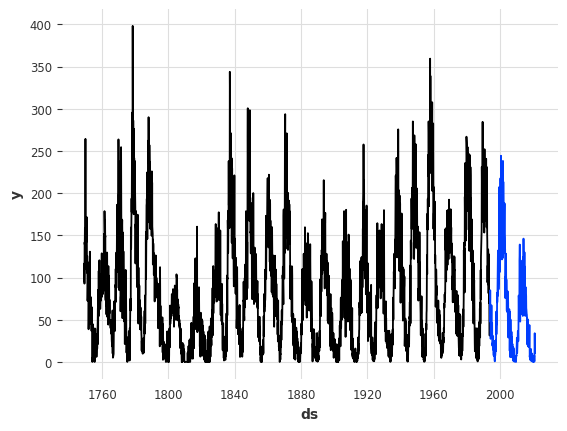

In [7]:
sns.lineplot(data=sunspots.train_df, x="ds", y="y")
sns.lineplot(data=sunspots.val_df, x="ds", y="y")
plt.show()

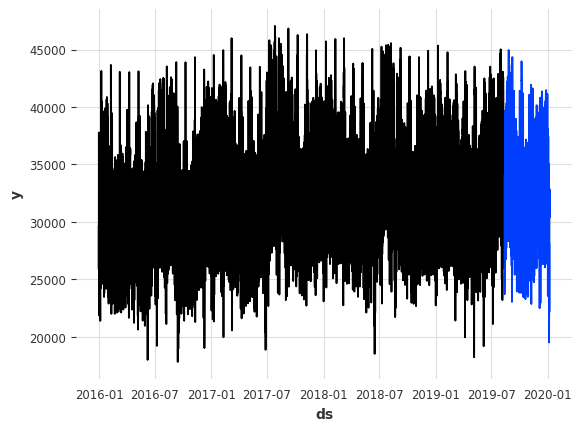

In [8]:
sns.lineplot(data=electricity.train_df, x="ds", y="y")
sns.lineplot(data=electricity.val_df, x="ds", y="y")
plt.show()

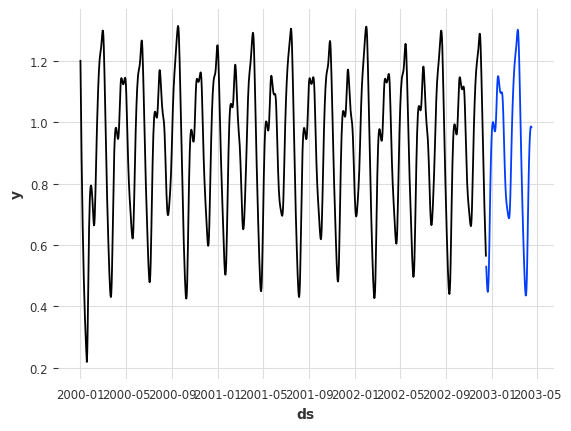

In [9]:
sns.lineplot(data=mackey_glass.train_df, x="ds", y="y")
sns.lineplot(data=mackey_glass.val_df, x="ds", y="y")
plt.show()

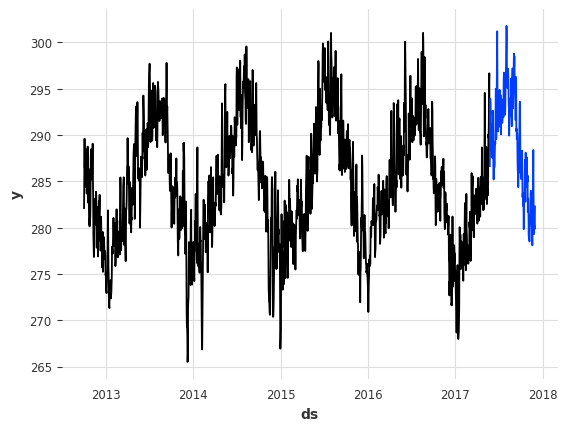

In [10]:
sns.lineplot(data=temperature.train_df, x="ds", y="y")
sns.lineplot(data=temperature.val_df, x="ds", y="y")
plt.show()

# Forecasting with Prophet

## Train model

In [7]:
model_name = "prophet"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
prophet_params = {
    dl.DATASET.SUNSPOTS: {
        "seasonality_mode": "multiplicative",
        "daily_seasonality": False,
        "weekly_seasonality": False,
        "custom_seasonality": int(11 * 365),
        "changepoint_prior_scale": 0.1,
        "seasonality_prior_scale": 1.0,
    },
    dl.DATASET.ELECTRICITY: {
        "changepoint_prior_scale": 0.01,
        "seasonality_prior_scale": 0.01,
        "seasonality_mode": "additive",
    },
    dl.DATASET.MACKEY_GLASS: {
        "changepoint_prior_scale": 0.1,
        "seasonality_prior_scale": 1.0,
        "seasonality_mode": "multiplicative",
        "custom_seasonality": 100,
    },
    dl.DATASET.TEMPERATURE: {
        "changepoint_prior_scale": 0.1,
        "seasonality_prior_scale": 1.0,
        "seasonality_mode": "additive",
    },
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = prophet_params[dataset.name]
    model = predictors.ProphetPredictor(**params)
    model.fit(df_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938, 2)


10:31:37 - cmdstanpy - INFO - Chain [1] start processing
10:31:39 - cmdstanpy - INFO - Chain [1] done processing


DATASET.ELECTRICITY
(31707, 2)


10:31:43 - cmdstanpy - INFO - Chain [1] start processing
10:31:56 - cmdstanpy - INFO - Chain [1] done processing


DATASET.MACKEY_GLASS
(1080, 2)


10:31:56 - cmdstanpy - INFO - Chain [1] start processing
10:31:57 - cmdstanpy - INFO - Chain [1] done processing


DATASET.TEMPERATURE
(1697, 2)


10:31:58 - cmdstanpy - INFO - Chain [1] start processing
10:31:58 - cmdstanpy - INFO - Chain [1] done processing


## Evaluate model

DATASET.SUNSPOTS


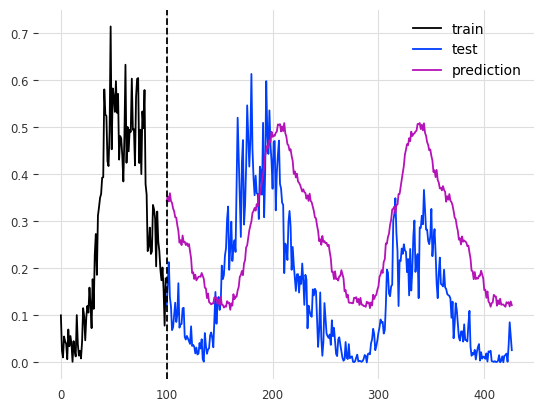

10 steps horizon - rmse = 0.2161
50 steps horizon - rmse = 0.1611
100 steps horizon - rmse = 0.1541
200 steps horizon - rmse = 0.1598
300 steps horizon - rmse = 0.1711
327 steps horizon - rmse = 0.1673


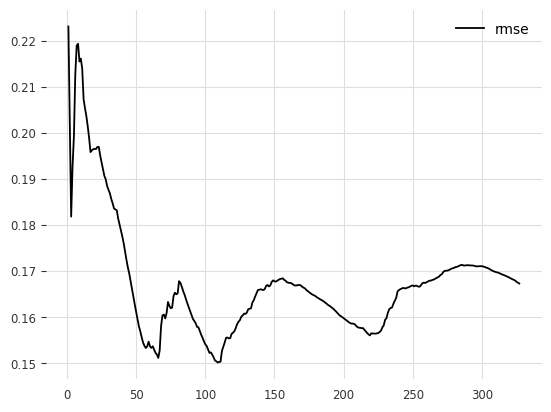


******************************

DATASET.ELECTRICITY


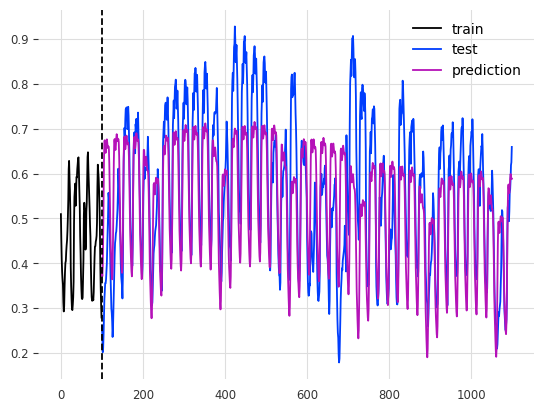

10 steps horizon - rmse = 0.274
50 steps horizon - rmse = 0.1925
100 steps horizon - rmse = 0.1398
200 steps horizon - rmse = 0.1101
300 steps horizon - rmse = 0.1034
1000 steps horizon - rmse = 0.1143
3524 steps horizon - rmse = 0.1048


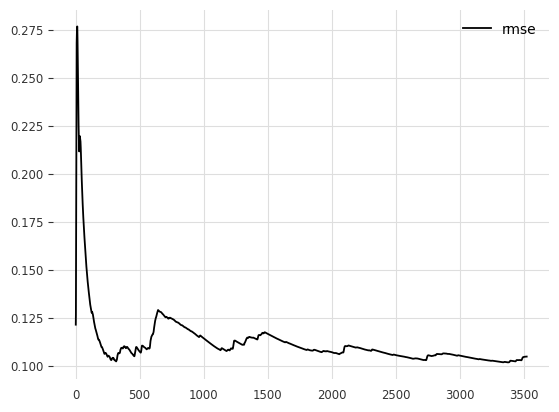


******************************

DATASET.MACKEY_GLASS


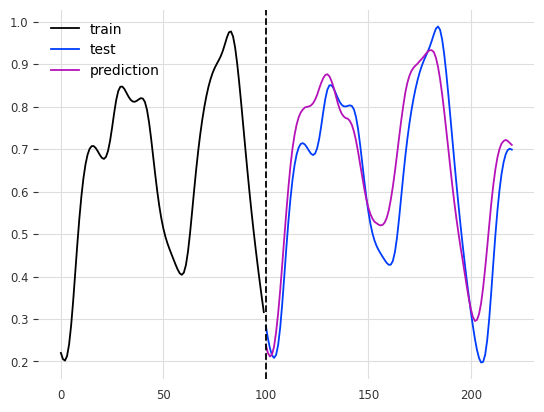

10 steps horizon - rmse = 0.0609
50 steps horizon - rmse = 0.0679
100 steps horizon - rmse = 0.0857
121 steps horizon - rmse = 0.0943


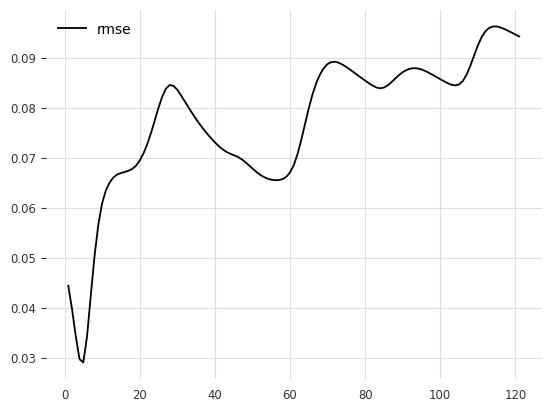


******************************

DATASET.TEMPERATURE


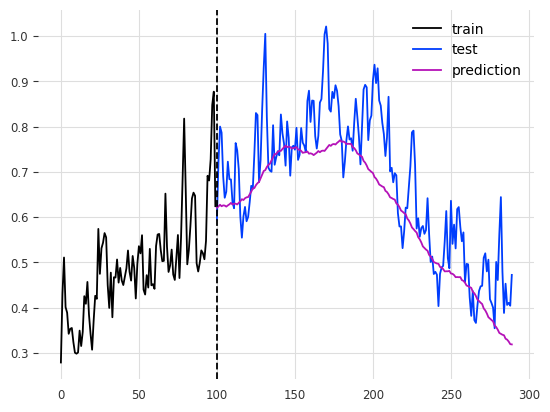

10 steps horizon - rmse = 0.0934
50 steps horizon - rmse = 0.0889
100 steps horizon - rmse = 0.0972
190 steps horizon - rmse = 0.1024


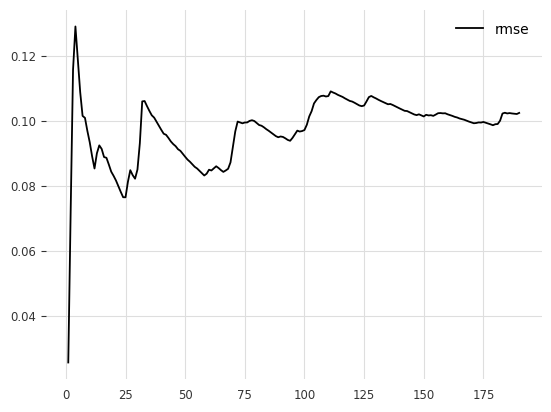


******************************



In [8]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(dataset.df_val[["ds"]])

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with SARIMA

## Train model

In [9]:
model_name = "sarima"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
sarima_params = {
    dl.DATASET.SUNSPOTS: {
        "order": (5, 0, 5),
        "seasonal_order": (2, 0, 2, 130),
    },
    dl.DATASET.ELECTRICITY: {
        "order": (3, 0, 5),
        "seasonal_order": (1, 0, 2, 24),
    },
    dl.DATASET.MACKEY_GLASS: {
        "order": (5, 0, 5),
        "seasonal_order": (2, 0, 2, 100),
    },
    dl.DATASET.TEMPERATURE: {
        "order": (5, 0, 5),
        "seasonal_order": (2, 0, 2, 365),
    },
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    X_train = df_train.y.values
    print(X_train.shape)
    params = sarima_params[dataset.name]
    model = predictors.SARIMAPredictor(**params)
    model.fit(X_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938,)


KeyboardInterrupt: 

## Evaluate model

DATASET.SUNSPOTS


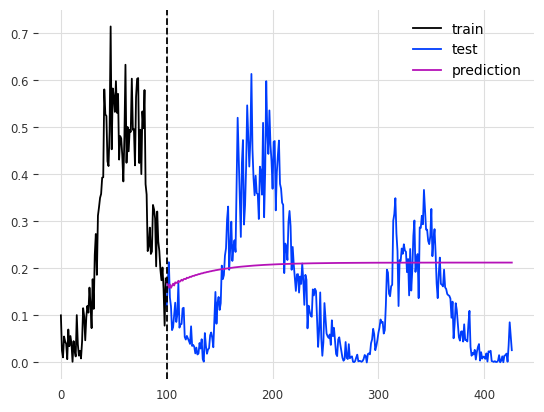

10 steps horizon - rmse = 0.0619
50 steps horizon - rmse = 0.1218
100 steps horizon - rmse = 0.1627
200 steps horizon - rmse = 0.1593
300 steps horizon - rmse = 0.1448
327 steps horizon - rmse = 0.1499


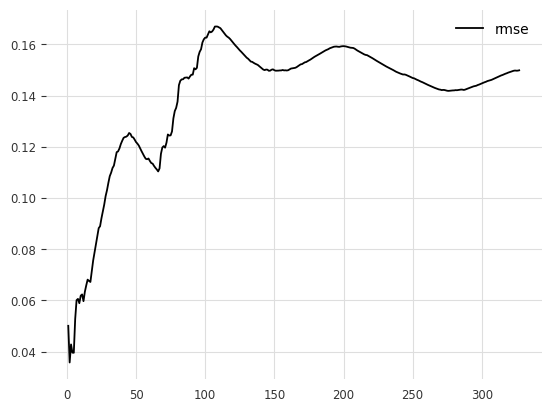


******************************

DATASET.ELECTRICITY


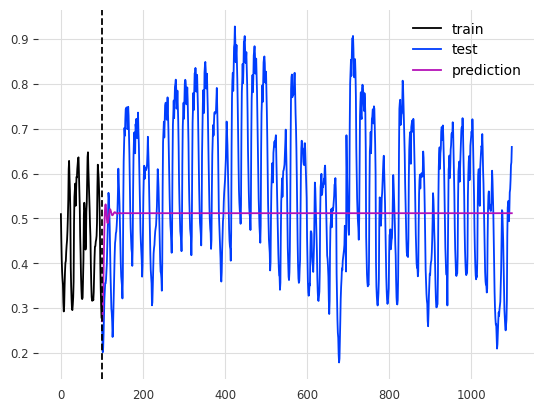

10 steps horizon - rmse = 0.1343
50 steps horizon - rmse = 0.1277
100 steps horizon - rmse = 0.1415
200 steps horizon - rmse = 0.147
300 steps horizon - rmse = 0.1652
1000 steps horizon - rmse = 0.1679
3524 steps horizon - rmse = 0.1586


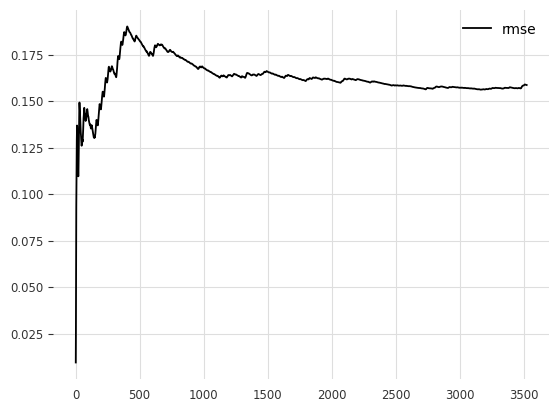


******************************

DATASET.MACKEY_GLASS


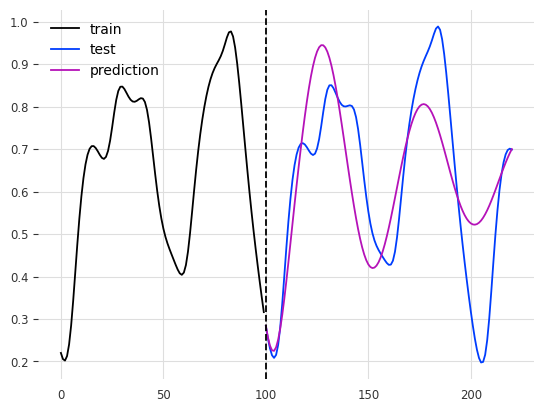

10 steps horizon - rmse = 0.0212
50 steps horizon - rmse = 0.129
100 steps horizon - rmse = 0.125
121 steps horizon - rmse = 0.144


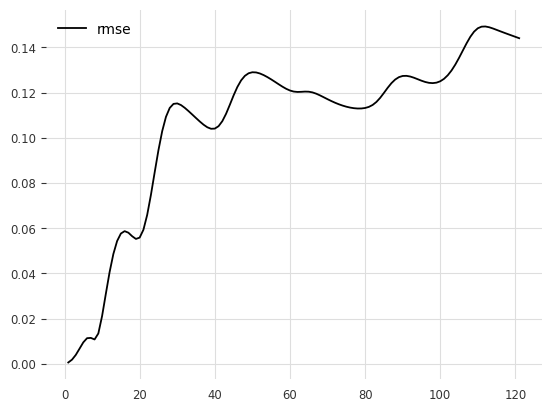


******************************

DATASET.TEMPERATURE


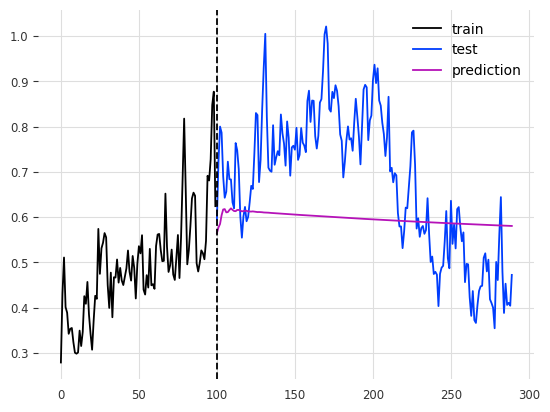

10 steps horizon - rmse = 0.1144
50 steps horizon - rmse = 0.1439
100 steps horizon - rmse = 0.1924
190 steps horizon - rmse = 0.1694


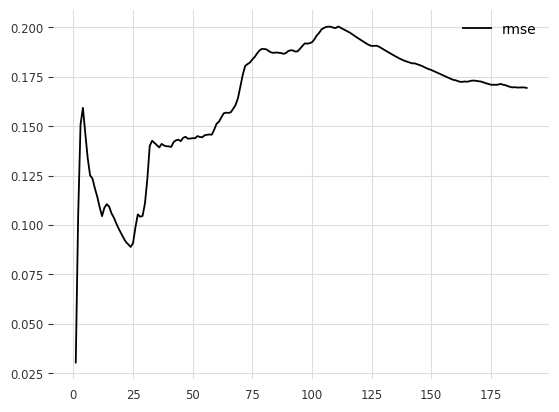


******************************



In [14]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(y_val.shape[0])
    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with TFT (one step ahead)

## Evaluate pretrained models

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


DATASET.SUNSPOTS
/Users/czyjtu/dev/time-series-forecasting/models/tft/sunspots01:52:41
Predicting DataLoader 0: 100%|██████████| 1/1 [00:26<00:00, 26.37s/it]


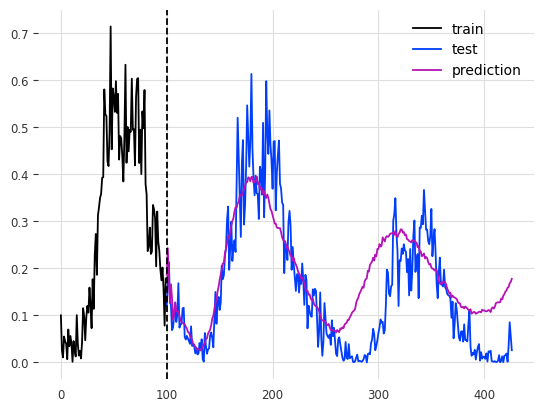

10 steps horizon - rmse = 0.0426
50 steps horizon - rmse = 0.0304
100 steps horizon - rmse = 0.0679
200 steps horizon - rmse = 0.0823
300 steps horizon - rmse = 0.0821
327 steps horizon - rmse = 0.0857


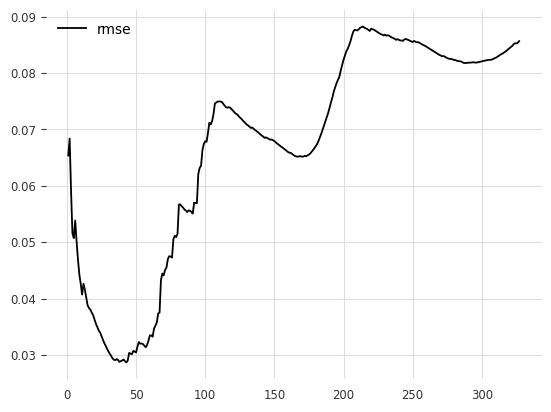

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



******************************

DATASET.ELECTRICITY
/Users/czyjtu/dev/time-series-forecasting/models/tft/electricity08:06:31


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [04:39<00:00, 279.31s/it]


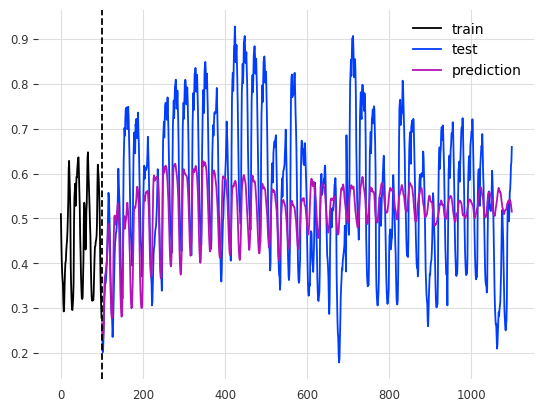

10 steps horizon - rmse = 0.0242
50 steps horizon - rmse = 0.0574
100 steps horizon - rmse = 0.1198
200 steps horizon - rmse = 0.1141
300 steps horizon - rmse = 0.1241
1000 steps horizon - rmse = 0.1439
3524 steps horizon - rmse = 0.1521


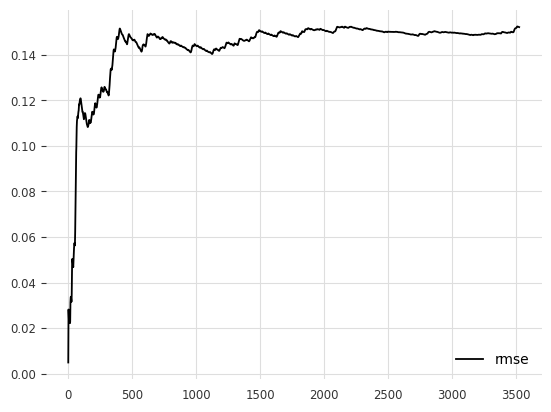

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



******************************

DATASET.MACKEY_GLASS
/Users/czyjtu/dev/time-series-forecasting/models/tft/mackey_glass08:16:47
Predicting DataLoader 0: 100%|██████████| 1/1 [00:09<00:00,  9.47s/it]


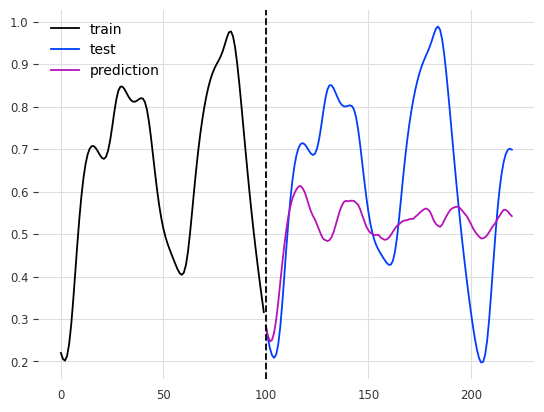

10 steps horizon - rmse = 0.068
50 steps horizon - rmse = 0.1881
100 steps horizon - rmse = 0.2176
121 steps horizon - rmse = 0.214


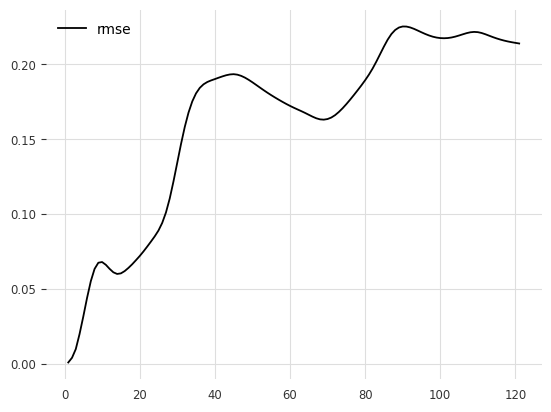

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



******************************

DATASET.TEMPERATURE
/Users/czyjtu/dev/time-series-forecasting/models/tft/temperature08:33:50


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:15<00:00, 15.11s/it]


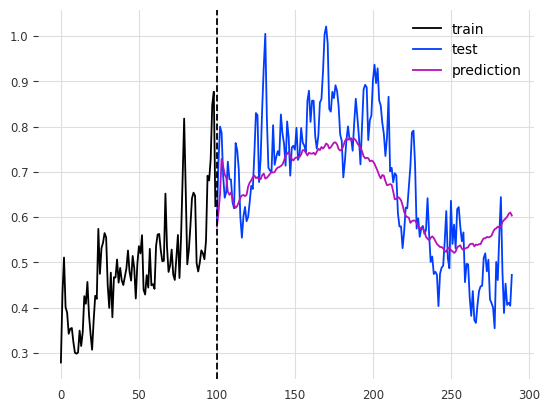

10 steps horizon - rmse = 0.0699
50 steps horizon - rmse = 0.0891
100 steps horizon - rmse = 0.0948
190 steps horizon - rmse = 0.1015


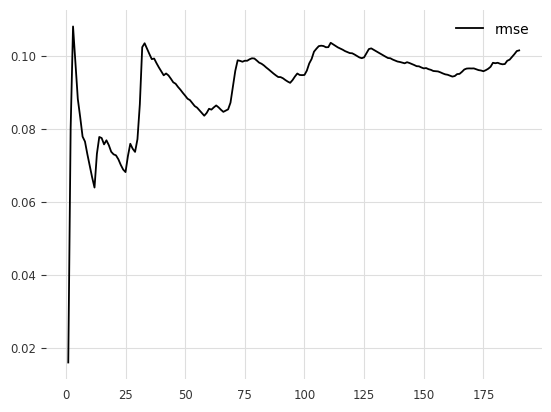


******************************



In [12]:
from collections import defaultdict

model_name = "tft-autoregresive"
WEIGHTS_DIR = Path().cwd().parent / "models/tft"

EVALUATION_RESULTS[model_name] = defaultdict(dict)

datasets = [sunspots, electricity, mackey_glass, temperature]

for dataset in datasets:
    print(dataset.name)
    model_fname, model_covariates = predictors.get_tft_weights_covariates(dataset.name, multihorizon=False)
    model_path = str(WEIGHTS_DIR / model_fname)
    print(model_path)

    y_pred = predictors.get_tft_predictions(model_path, dataset, model_covariates)
    y_val = dataset.y_val
    y_train = dataset.y_train

    plot_predictions(y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with XGBoost - autoregressive

## Train model

In [15]:
model_name = "xgboost - ar"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
xgboost_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 300,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": True,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": None,
        "mode": 1
    }
}

for dataset in datasets:
    print(dataset.name)
    X_train = dataset.X_train
    y_train = dataset.y_train
    print(dataset.df_train.shape)
    params = xgboost_params[dataset.name]
    model = predictors.XGBoostPredictor(**params)
    model.fit(X=X_train, y=y_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938, 2)
DATASET.ELECTRICITY
(31707, 2)
DATASET.MACKEY_GLASS
(1080, 2)
DATASET.TEMPERATURE
(1697, 2)


## Evaluate model

DATASET.SUNSPOTS


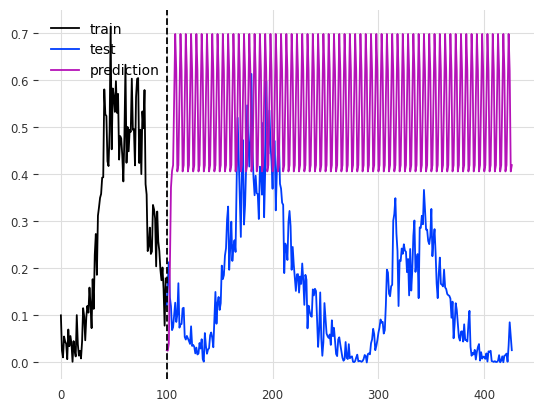

10 steps horizon - rmse = 0.3434
50 steps horizon - rmse = 0.4689
100 steps horizon - rmse = 0.3732
200 steps horizon - rmse = 0.4156
300 steps horizon - rmse = 0.4132
327 steps horizon - rmse = 0.4238


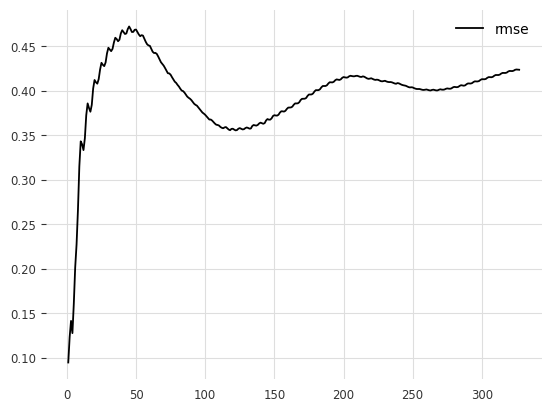


******************************

DATASET.ELECTRICITY


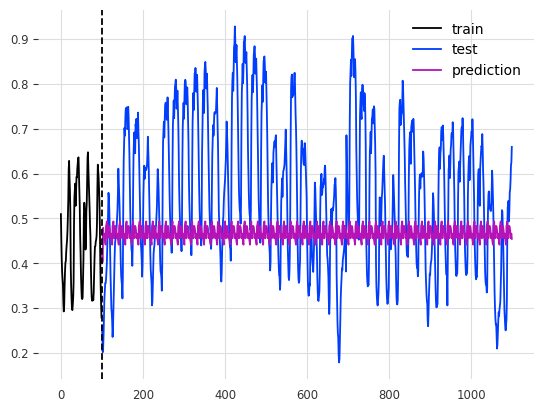

10 steps horizon - rmse = 0.173
50 steps horizon - rmse = 0.1225
100 steps horizon - rmse = 0.1553
200 steps horizon - rmse = 0.1662
300 steps horizon - rmse = 0.1892
1000 steps horizon - rmse = 0.1862
3524 steps horizon - rmse = 0.1662


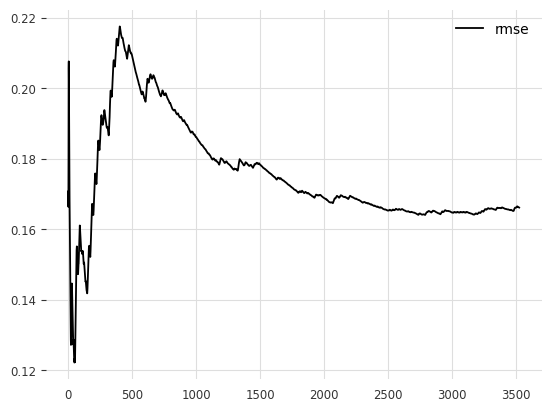


******************************

DATASET.MACKEY_GLASS


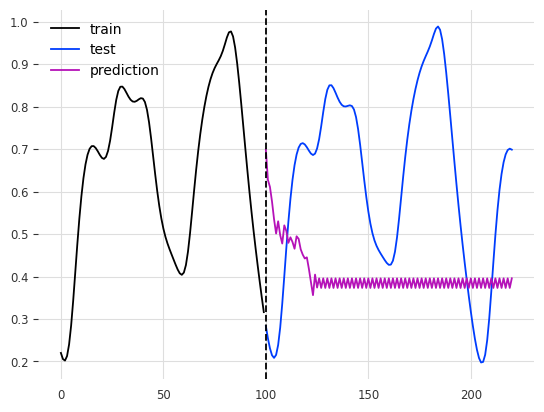

10 steps horizon - rmse = 0.3068
50 steps horizon - rmse = 0.336
100 steps horizon - rmse = 0.3462
121 steps horizon - rmse = 0.3256


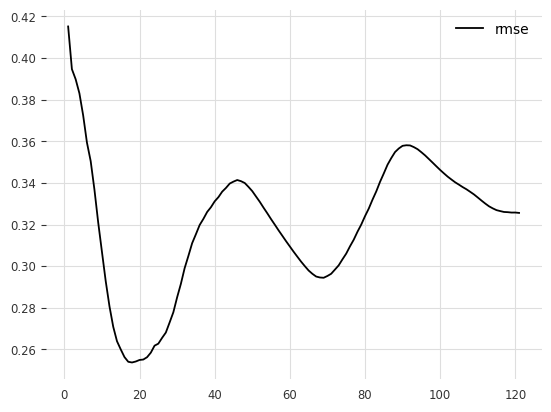


******************************

DATASET.TEMPERATURE


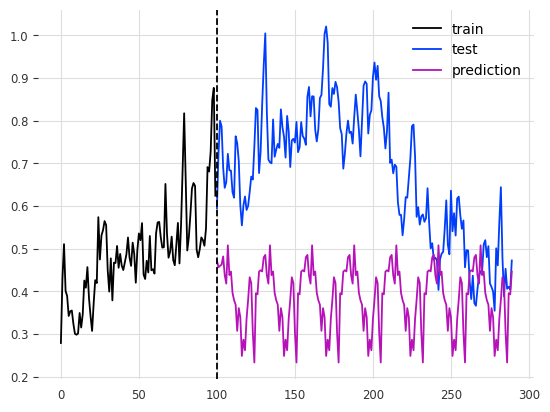

10 steps horizon - rmse = 0.2472
50 steps horizon - rmse = 0.3467
100 steps horizon - rmse = 0.4027
190 steps horizon - rmse = 0.3392


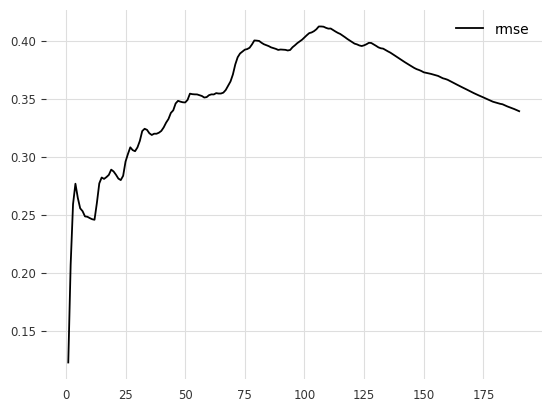


******************************



In [11]:
forecasts = {}
for i, dataset in enumerate(datasets):
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(y_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with XGBoost Multi-horizon with future covariates

## Train model

In [21]:
model_name = "xgboost - multihorizon-covariates"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
xgboost_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 300,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "50 years lag": "18262 days",
            "40 years lag": "14610 days",
            "30 years lag": "10958 days"
        },
        "mode": 3
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": True,
        "lags": {
            "8 months lag": "242 days",
            "6 months lag": "182 days",
            "4 months lag": "91 days"
        },
        "mode": 3
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "300 days lag": "300 days",
            "2 months lag": "61 days",
            "3 months lag": "91 days"
        },
        "mode": 3
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "4 months lag": "91 days",
            "1 month lag": "30 days",
            "15 days lag": "15 days"
        },
        "mode": 3
    }
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = xgboost_params[dataset.name]
    model = predictors.XGBoostPredictor(**params)
    model.fit(df=df_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938, 2)


c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY
(31707, 2)


c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.MACKEY_GLASS
(1080, 2)


c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.TEMPERATURE
(1697, 2)


c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


## Evaluate model

c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.SUNSPOTS


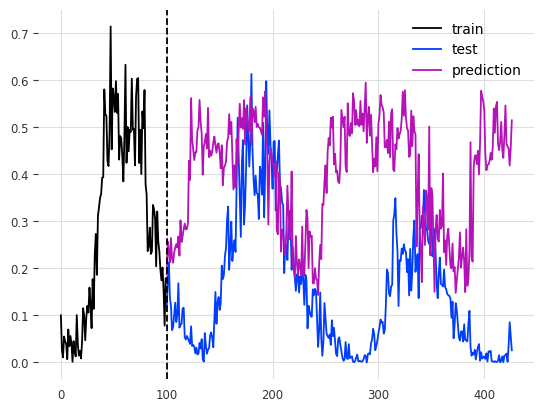

10 steps horizon - rmse = 0.1182
50 steps horizon - rmse = 0.3369
100 steps horizon - rmse = 0.2654
200 steps horizon - rmse = 0.302
300 steps horizon - rmse = 0.2898
327 steps horizon - rmse = 0.3072


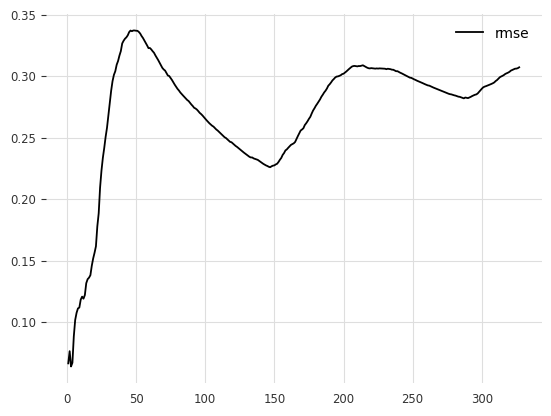


******************************



c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY


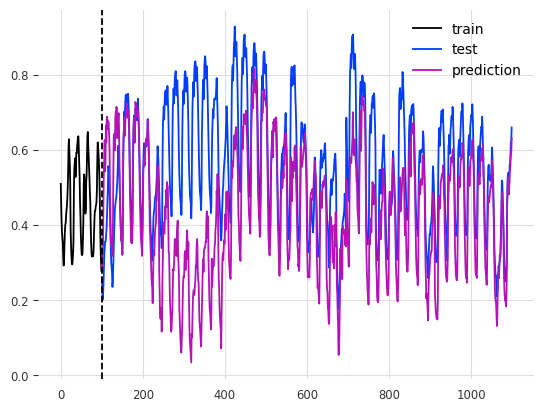

10 steps horizon - rmse = 0.1952
50 steps horizon - rmse = 0.1678
100 steps horizon - rmse = 0.1219
200 steps horizon - rmse = 0.2137
300 steps horizon - rmse = 0.2874
1000 steps horizon - rmse = 0.1888
3524 steps horizon - rmse = 0.156


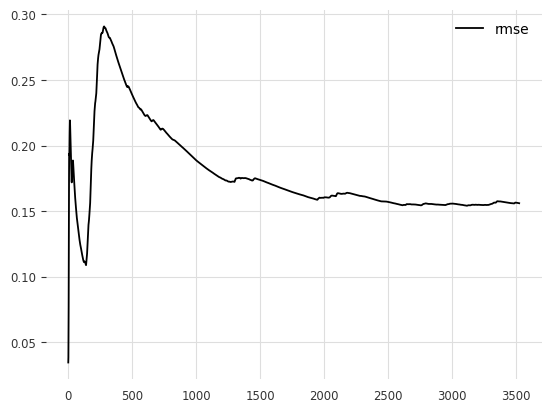


******************************

DATASET.MACKEY_GLASS


c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


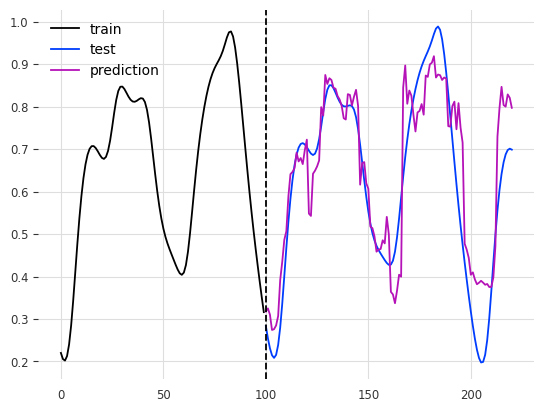

10 steps horizon - rmse = 0.0771
50 steps horizon - rmse = 0.0554
100 steps horizon - rmse = 0.0848
121 steps horizon - rmse = 0.0963


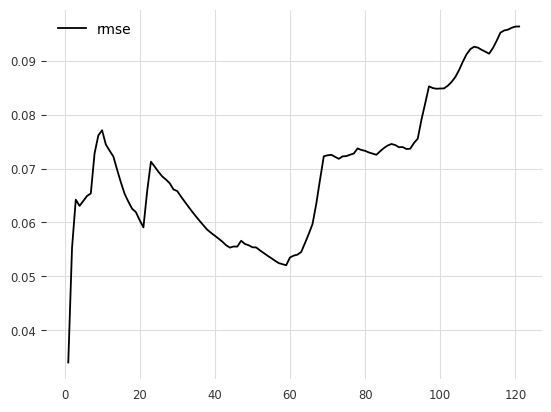


******************************

DATASET.TEMPERATURE


c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


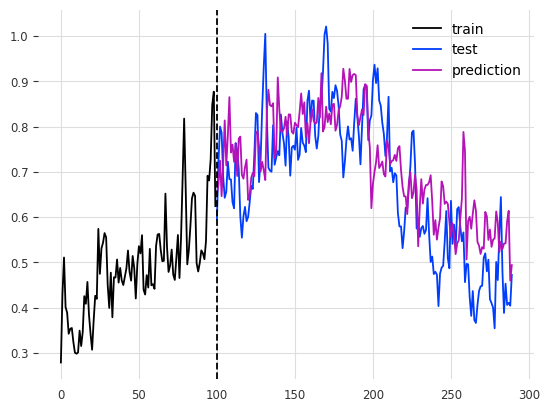

10 steps horizon - rmse = 0.102
50 steps horizon - rmse = 0.1054
100 steps horizon - rmse = 0.1013
190 steps horizon - rmse = 0.1126


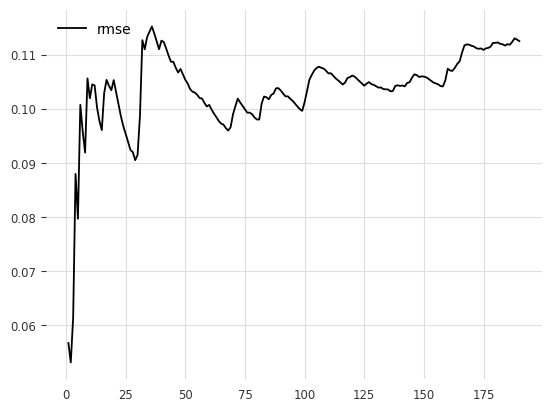


******************************



In [22]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    df_val = pd.DataFrame({"ds": dataset.y_val_df.ds})
    model = models[dataset.name]
    y_pred = model.forecast(df_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with LightGBM - autoregressive

## Train model

In [19]:
model_name = "lightgbm - ar"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
lightgbm_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 300,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": True,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": None,
        "mode": 1
    }
}

for dataset in datasets:
    print(dataset.name)
    X_train = dataset.X_train
    y_train = dataset.y_train.ravel()
    print(dataset.df_train.shape)
    params = lightgbm_params[dataset.name]
    model = predictors.LightGBMPredictor(**params)
    model.fit(X=X_train, y=y_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938, 2)
DATASET.ELECTRICITY
(31707, 2)
DATASET.MACKEY_GLASS
(1080, 2)
DATASET.TEMPERATURE
(1697, 2)


## Evaluate model

DATASET.SUNSPOTS


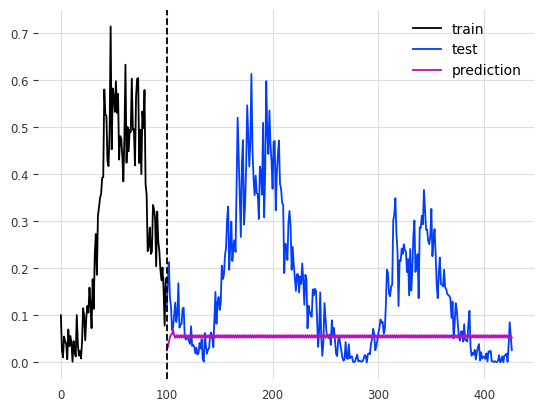

10 steps horizon - rmse = 0.0873
50 steps horizon - rmse = 0.0528
100 steps horizon - rmse = 0.2345
200 steps horizon - rmse = 0.1938
300 steps horizon - rmse = 0.1779
327 steps horizon - rmse = 0.1709


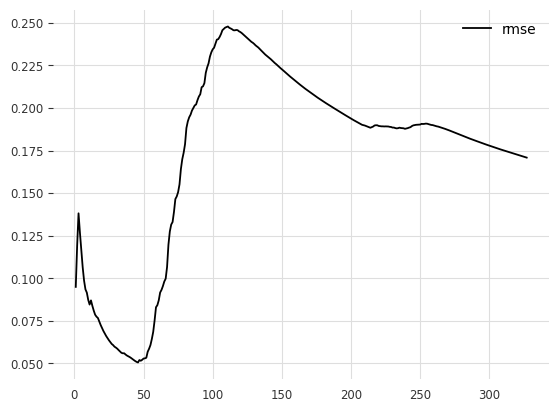


******************************

DATASET.ELECTRICITY


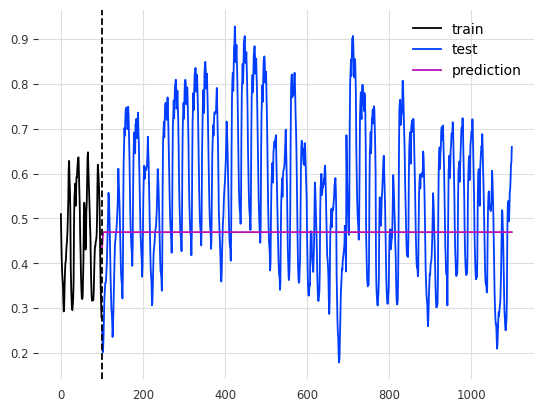

10 steps horizon - rmse = 0.1881
50 steps horizon - rmse = 0.1252
100 steps horizon - rmse = 0.1557
200 steps horizon - rmse = 0.1655
300 steps horizon - rmse = 0.1886
1000 steps horizon - rmse = 0.1853
3524 steps horizon - rmse = 0.1651


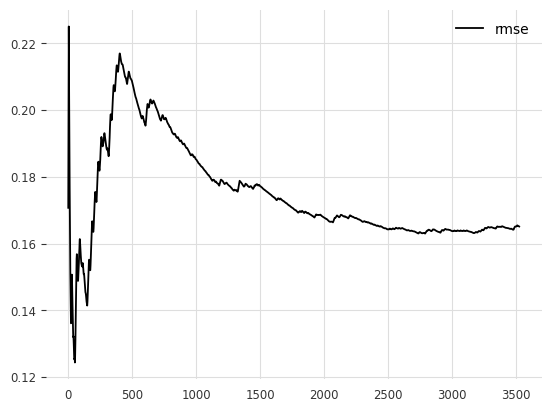


******************************

DATASET.MACKEY_GLASS


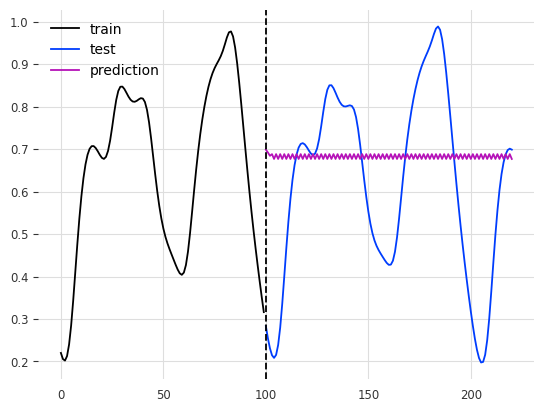

10 steps horizon - rmse = 0.4234
50 steps horizon - rmse = 0.21
100 steps horizon - rmse = 0.2085
121 steps horizon - rmse = 0.2316


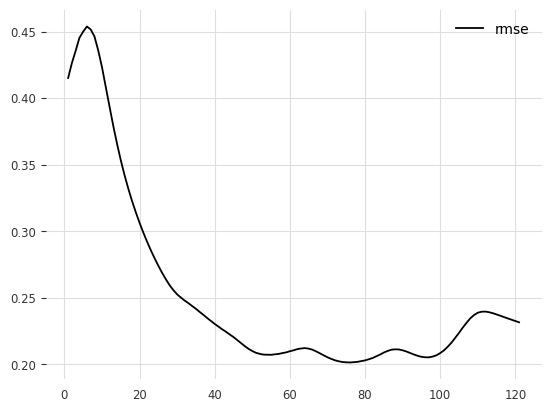


******************************

DATASET.TEMPERATURE


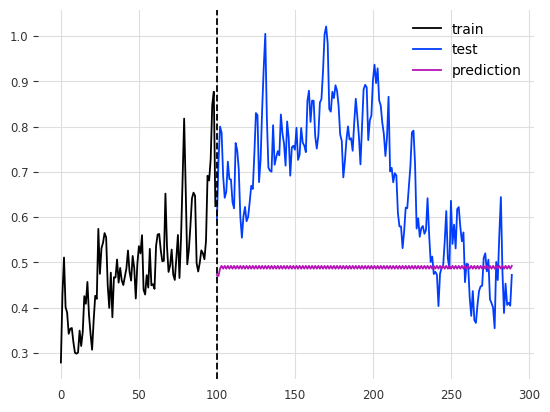

10 steps horizon - rmse = 0.2204
50 steps horizon - rmse = 0.2495
100 steps horizon - rmse = 0.2973
190 steps horizon - rmse = 0.2435


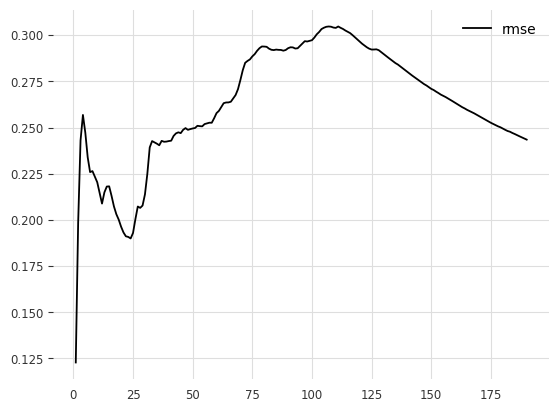


******************************



In [20]:
forecasts = {}
for i, dataset in enumerate(datasets):
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(y_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with LightGBM Multi-horizon with future covariates

# Train model

In [23]:
model_name = "lightgbm - multihorizon-covariates"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
lightgbm_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 1000,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "50 years lag": "18262 days",
            "40 years lag": "14610 days",
            "30 years lag": "10958 days"
        },
        "mode": 3
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": True,
        "lags": {
            "8 months lag": "242 days",
            "6 months lag": "182 days",
            "4 months lag": "91 days"
        },
        "mode": 3
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "300 days lag": "300 days",
            "2 months lag": "61 days",
            "3 months lag": "91 days"
        },
        "mode": 3
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "4 months lag": "91 days",
            "1 months lag": "30 days",
            "15 days lag": "15 days"
        },
        "mode": 3
    }
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = lightgbm_params[dataset.name]
    model = predictors.LightGBMPredictor(**params)
    model.fit(df_train)
    models[dataset.name] = model 

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938, 2)


c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY
(31707, 2)


c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.MACKEY_GLASS
(1080, 2)
DATASET.TEMPERATURE
(1697, 2)


c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)
c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


## Evaluate model

c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.SUNSPOTS


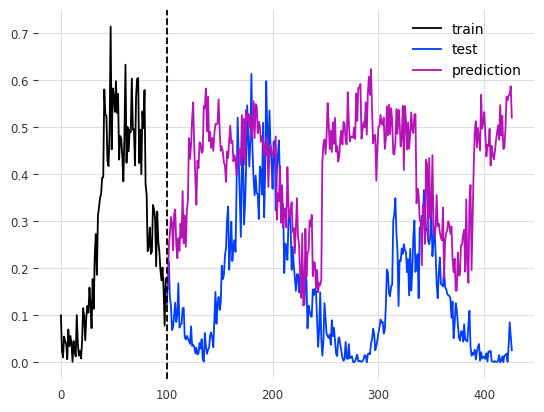

10 steps horizon - rmse = 0.1579
50 steps horizon - rmse = 0.3517
100 steps horizon - rmse = 0.2732
200 steps horizon - rmse = 0.3142
300 steps horizon - rmse = 0.2995
327 steps horizon - rmse = 0.3184


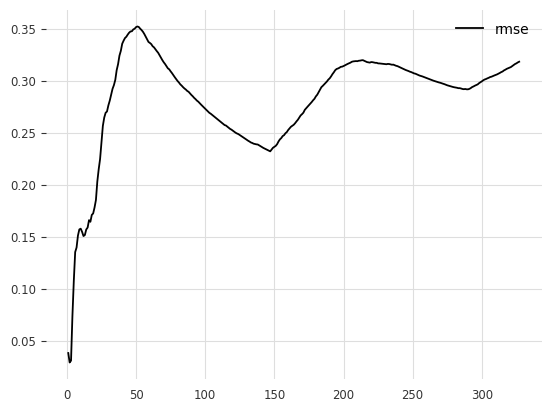


******************************



c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY


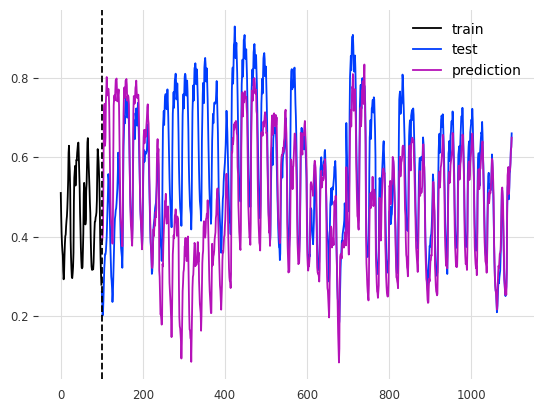

10 steps horizon - rmse = 0.2965
50 steps horizon - rmse = 0.2515
100 steps horizon - rmse = 0.1816
200 steps horizon - rmse = 0.2089
300 steps horizon - rmse = 0.2556
1000 steps horizon - rmse = 0.1574
3524 steps horizon - rmse = 0.1196


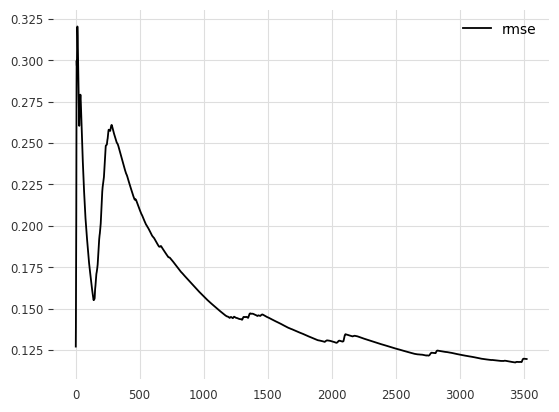


******************************

DATASET.MACKEY_GLASS


c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


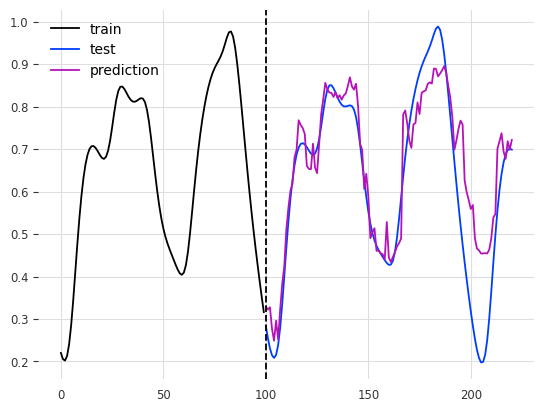

10 steps horizon - rmse = 0.0573
50 steps horizon - rmse = 0.0413
100 steps horizon - rmse = 0.0763
121 steps horizon - rmse = 0.1008


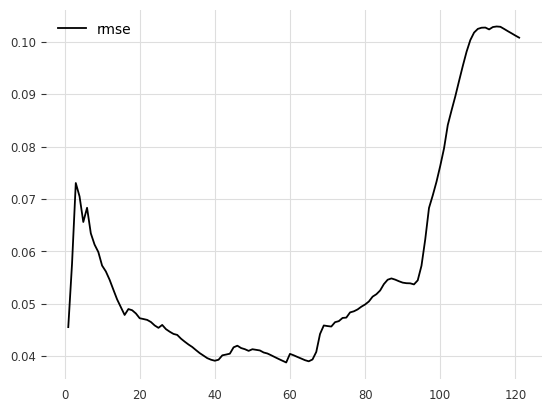


******************************

DATASET.TEMPERATURE


c:\Users\Kamil\Universe\eksploracja-danych\time-series-forecasting\utils\predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


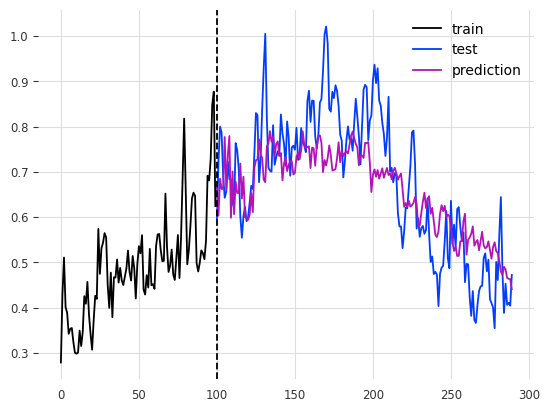

10 steps horizon - rmse = 0.091
50 steps horizon - rmse = 0.0909
100 steps horizon - rmse = 0.1023
190 steps horizon - rmse = 0.1032


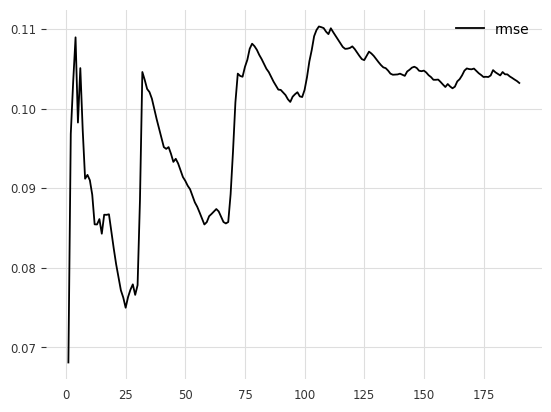


******************************



In [24]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    df_val = pd.DataFrame({"ds": dataset.y_val_df.ds})
    model = models[dataset.name]
    y_pred = model.forecast(df_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with TFT (multihorizon)

DATASET.SUNSPOTS
/Users/czyjtu/dev/time-series-forecasting/models/tft/sunspots_i400_h133_21_28_12


/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.2, which is newer than your current Lightning version: v2.0.1
  rank_zero_warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (tr

Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


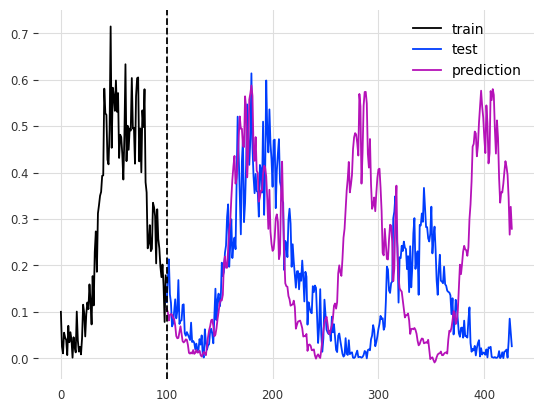

10 steps horizon - rmse = 0.0556
50 steps horizon - rmse = 0.0445
100 steps horizon - rmse = 0.0864
200 steps horizon - rmse = 0.19
300 steps horizon - rmse = 0.2054
327 steps horizon - rmse = 0.2322


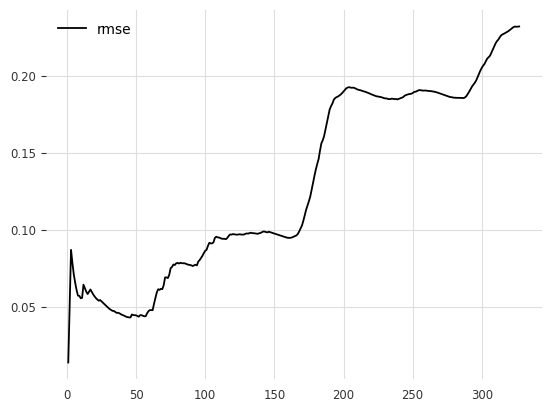


******************************

DATASET.ELECTRICITY
/Users/czyjtu/dev/time-series-forecasting/models/tft/electricity_i168_h24_21_49_52_best


/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.2, which is newer than your current Lightning version: v2.0.1
  rank_zero_warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (tr

Predicting DataLoader 0: 100%|██████████| 1/1 [00:30<00:00, 30.61s/it]


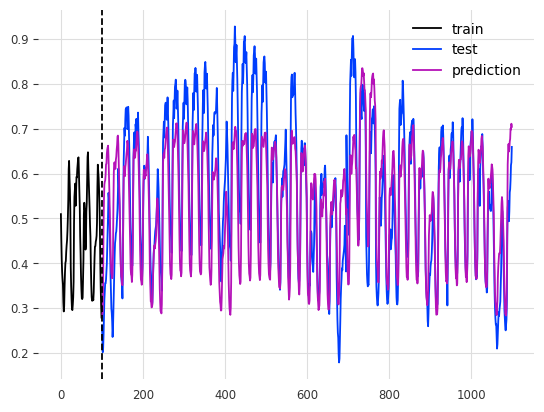

10 steps horizon - rmse = 0.2002
50 steps horizon - rmse = 0.1562
100 steps horizon - rmse = 0.1202
200 steps horizon - rmse = 0.0971
300 steps horizon - rmse = 0.1013
1000 steps horizon - rmse = 0.0951
3524 steps horizon - rmse = 0.1085


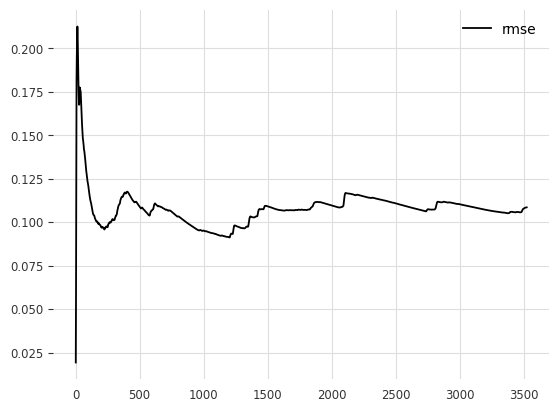

/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.2, which is newer than your current Lightning version: v2.0.1
  rank_zero_warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (tr


******************************

DATASET.MACKEY_GLASS
/Users/czyjtu/dev/time-series-forecasting/models/tft/mackey_glass_i100_h50_23_06_54_best
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


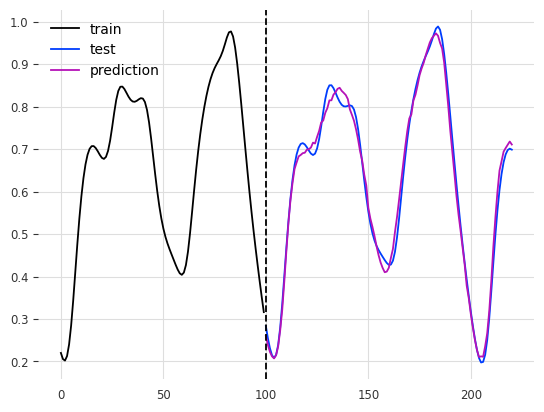

10 steps horizon - rmse = 0.0113
50 steps horizon - rmse = 0.0206
100 steps horizon - rmse = 0.0211
121 steps horizon - rmse = 0.0215


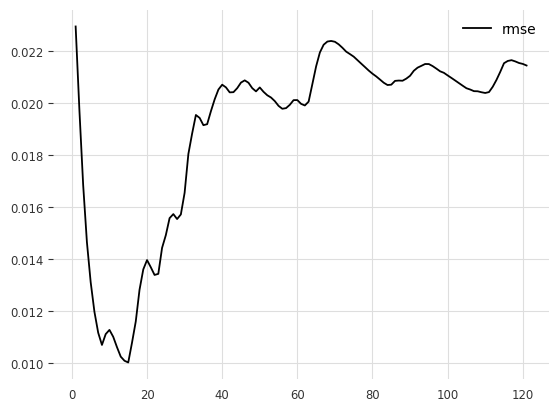

/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.2, which is newer than your current Lightning version: v2.0.1
  rank_zero_warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (tr


******************************

DATASET.TEMPERATURE
/Users/czyjtu/dev/time-series-forecasting/models/tft/temperature_i90_h30_23_00_27_best
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


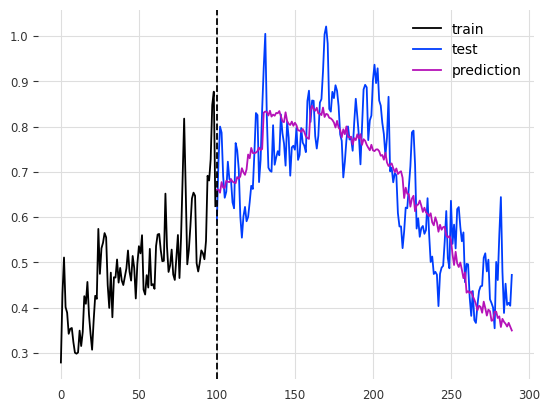

10 steps horizon - rmse = 0.0671
50 steps horizon - rmse = 0.0837
100 steps horizon - rmse = 0.078
190 steps horizon - rmse = 0.0849


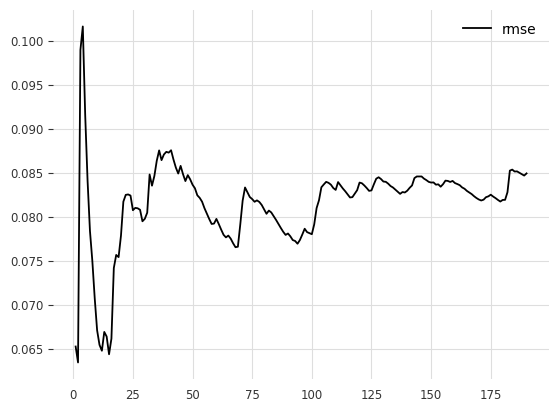


******************************



In [13]:
from collections import defaultdict

model_name = "tft-multihorizon-covariates"
WEIGHTS_DIR = Path().cwd().parent / "models/tft"

EVALUATION_RESULTS[model_name] = defaultdict(dict)

datasets = [sunspots, electricity, mackey_glass, temperature]

for dataset in datasets:
    print(dataset.name)
    model_fname, model_covariates = predictors.get_tft_weights_covariates(dataset.name, multihorizon=True)
    model_path = str(WEIGHTS_DIR / model_fname)
    print(model_path)

    y_pred = predictors.get_tft_predictions(model_path, dataset, model_covariates)
    y_val = dataset.y_val
    y_train = dataset.y_train

    plot_predictions(y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse


# Forecasting with ESN

## Train model

In [14]:
model_name = "esn"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
for dataset in datasets:
    print(dataset.name)
    X_train, y_train = dataset.X_train, dataset.y_train
    print(X_train.shape, y_train.shape)
    model = predictors.ESNPredictor(input_size=1, hidden_size=1000, output_size=1, num_layers=4)
    model.fit(X_train, y_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2937, 1) (2937, 1)
DATASET.ELECTRICITY
(31706, 1) (31706, 1)
DATASET.MACKEY_GLASS
(1079, 1) (1079, 1)
DATASET.TEMPERATURE
(1696, 1) (1696, 1)


## Evaluate model

DATASET.SUNSPOTS


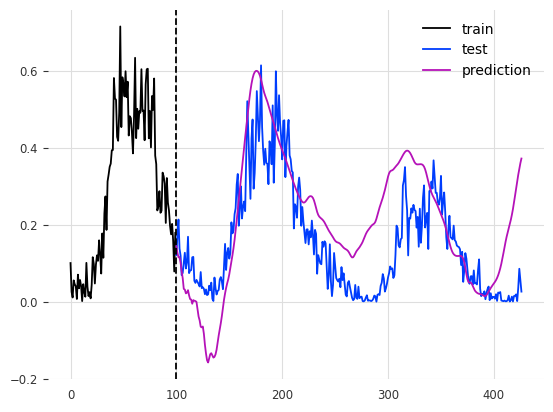

10 steps horizon - rmse = 0.0557
50 steps horizon - rmse = 0.1123
100 steps horizon - rmse = 0.121
200 steps horizon - rmse = 0.1248
300 steps horizon - rmse = 0.1224
327 steps horizon - rmse = 0.1301


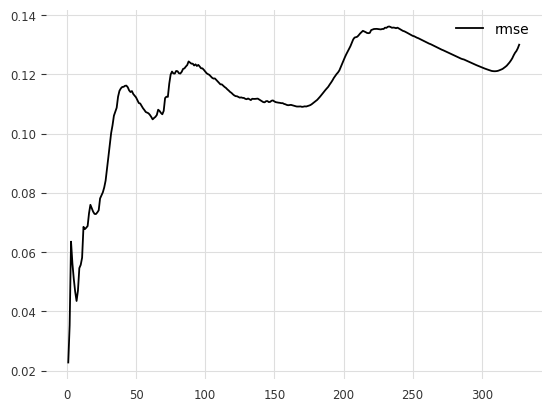


******************************

DATASET.ELECTRICITY


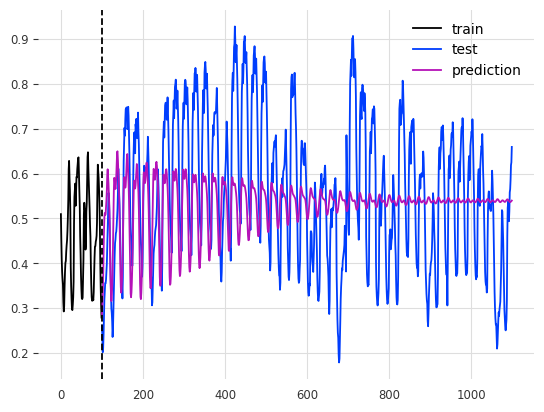

10 steps horizon - rmse = 0.1491
50 steps horizon - rmse = 0.1186
100 steps horizon - rmse = 0.1156
200 steps horizon - rmse = 0.1193
300 steps horizon - rmse = 0.136
1000 steps horizon - rmse = 0.1535
3524 steps horizon - rmse = 0.1581


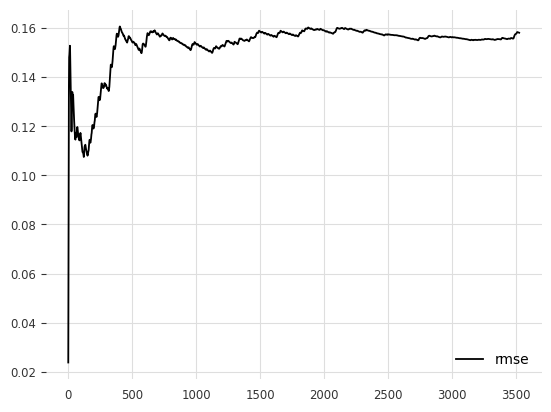


******************************

DATASET.MACKEY_GLASS


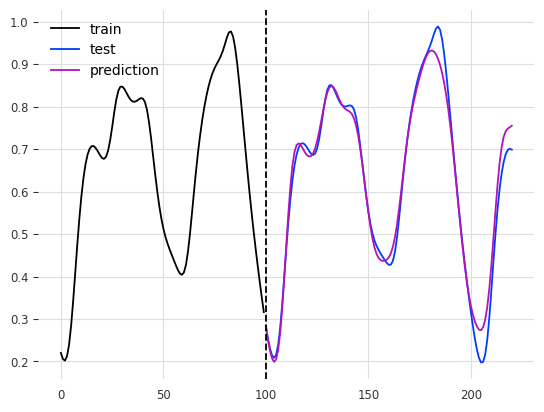

10 steps horizon - rmse = 0.0081
50 steps horizon - rmse = 0.0133
100 steps horizon - rmse = 0.0225
121 steps horizon - rmse = 0.0322


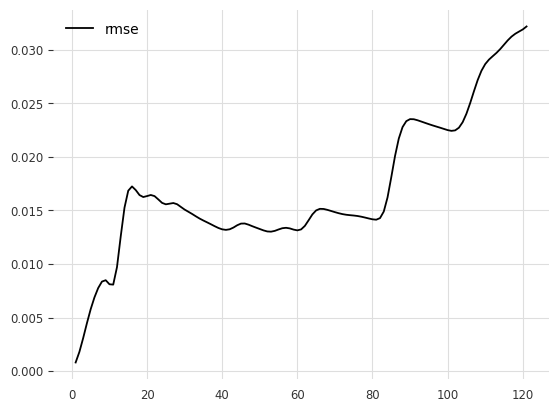


******************************

DATASET.TEMPERATURE


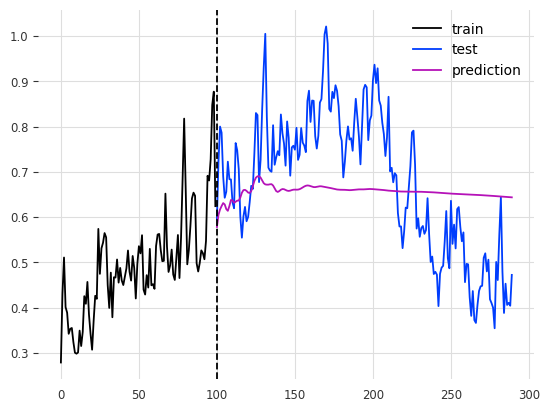

10 steps horizon - rmse = 0.0982
50 steps horizon - rmse = 0.1075
100 steps horizon - rmse = 0.1431
190 steps horizon - rmse = 0.1515


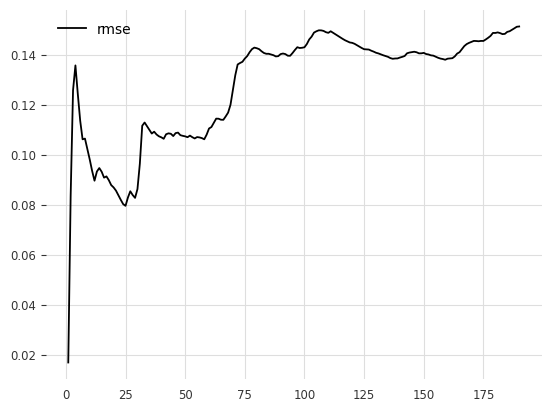


******************************



In [15]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(y_val.shape[0])
    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Evaluation

In [27]:
from darts.metrics import metrics
from darts.timeseries import TimeSeries
from IPython.display import display
from math import ceil

model_names = EVALUATION_RESULTS.keys()
EVALUATION_DF = pd.DataFrame(columns=["dataset name", "model name"])

darts_metrics = {
    "rmse": metrics.rmse,
    "dtw": metrics.dtw_metric,
    "mae": metrics.mae,
    "ope": metrics.ope,
}

In [28]:
def make_evaluation(dataset):
    eval_df = pd.DataFrame()
    dataset_name = dataset.name

    y_train = dataset.y_train[-MAX_PLOT_TRAIN: ].flatten()
    y_test = dataset.y_val[:MAX_PLOT_HORIZON].flatten()
    xrange_train = np.arange(y_train.shape[0])
    xrange_test = np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0])

    fig, axs = plt.subplots(ceil(len(model_names) / 2), 2, figsize=(15, 15))
    for num, model_name in enumerate(model_names):
        i = num // 2
        j = num % 2

        sns.lineplot(y=y_train, x=xrange_train, label="train", ax=axs[i, j])
        sns.lineplot(y=y_test, x=xrange_test, label="test", ax=axs[i, j])
        y_pred = EVALUATION_RESULTS[model_name][dataset_name]["prediction"].flatten()
        sns.lineplot(y=y_pred[:MAX_PLOT_HORIZON], x=xrange_test, label=model_name, ax=axs[i, j], color="green")
        axs[i, j].axvline(x=y_train.shape[0], linestyle="--", color="black")
        axs[i, j].set_title(f"model: {model_name}")
    plt.show()


    plt.figure(figsize=(7, 7))
    plt.title("RMSE")
    for model_name in model_names:
        rmse = EVALUATION_RESULTS[model_name][dataset_name]["rmse"][:MAX_PLOT_HORIZON]
        predicted_days = np.arange(1, rmse.shape[0]+1)
        sns.lineplot(y=rmse, x=predicted_days, label=model_name)
    plt.show()

    plt.figure(figsize=(7, 7))
    plt.title("RMSE - 50 steps")
    for model_name in model_names:
        rmse = EVALUATION_RESULTS[model_name][dataset_name]["rmse"][:50]
        predicted_days = np.arange(1, rmse.shape[0]+1)
        sns.lineplot(y=rmse, x=predicted_days, label=model_name)
    plt.show()

    HORIZONS = [1, 10, 20, 50, 100, 250]

    for model_name in model_names:
        rmse = EVALUATION_RESULTS[model_name][dataset_name]["rmse"]
        row = {"dataset name": [dataset_name.value], "model name": [model_name]}
        for h in HORIZONS:
            if h > rmse.shape[0]:
                row[f"rmse - {h}"] = [None]
                continue
            row[f"rmse - {h}"] = [rmse[h - 1]]

        y_pred = EVALUATION_RESULTS[model_name][dataset_name]["prediction"].flatten()
        pred = TimeSeries.from_values(y_pred)
        test = TimeSeries.from_values(y_test)

        for label, metric in darts_metrics.items():
            row[label] = [metric(test, pred)]

        eval_df = pd.concat([eval_df, pd.DataFrame(row)], ignore_index=True)

    darts_metrics_df = eval_df.loc[eval_df["dataset name"] == dataset_name][["model name"] + list(darts_metrics.keys())].copy()
    darts_metrics_df = darts_metrics_df.set_index("model name")
    darts_metrics_df = darts_metrics_df / darts_metrics_df.max(axis=0)
    darts_metrics_df = darts_metrics_df.stack().to_frame().reset_index()
    darts_metrics_df.columns = ["model", "metric", "normalized value"]

    plt.figure(figsize=(7, 7))
    sns.lineplot(data=darts_metrics_df, x="metric", y="normalized value", hue="model", marker="o")
    plt.show()

    display(eval_df.loc[eval_df["dataset name"] == dataset_name])

    return eval_df

## Mackey Glass

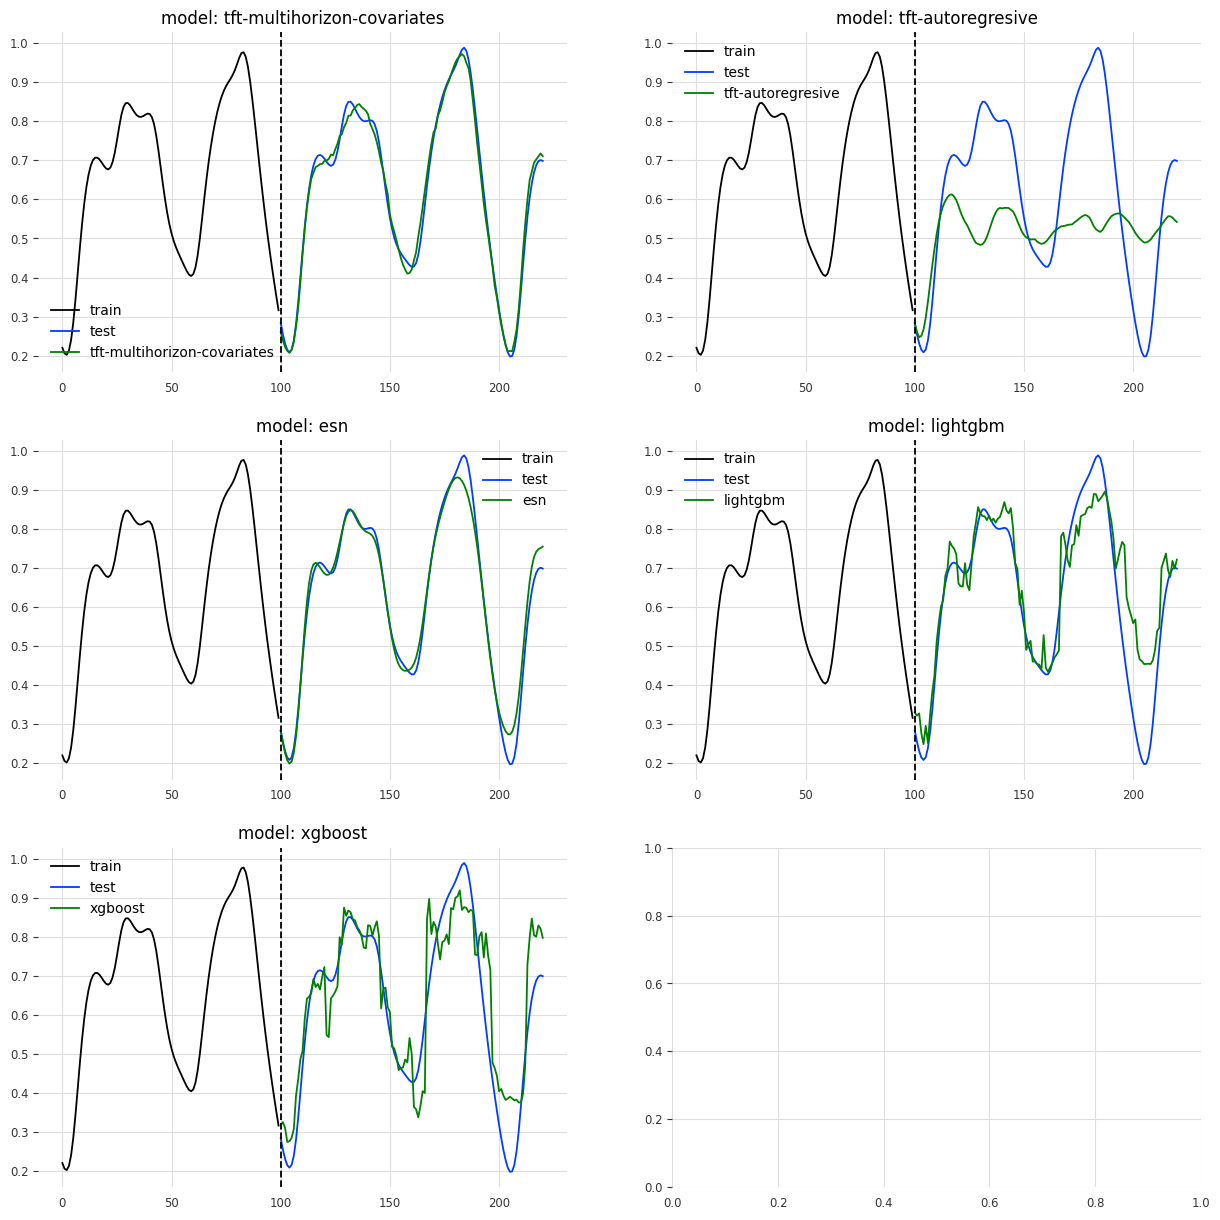

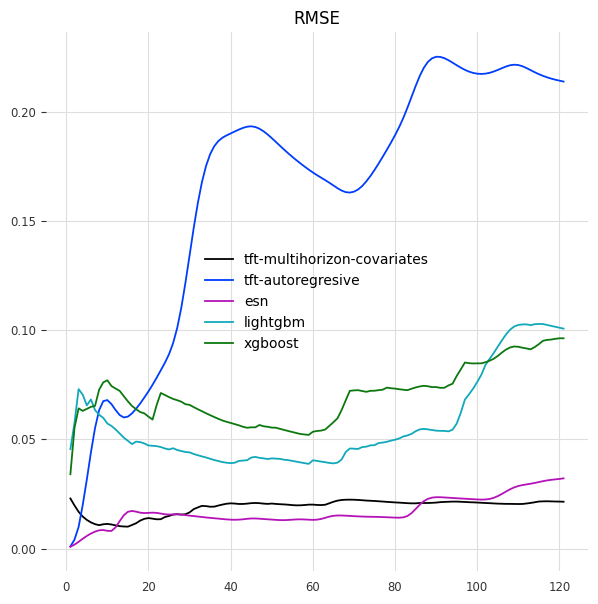

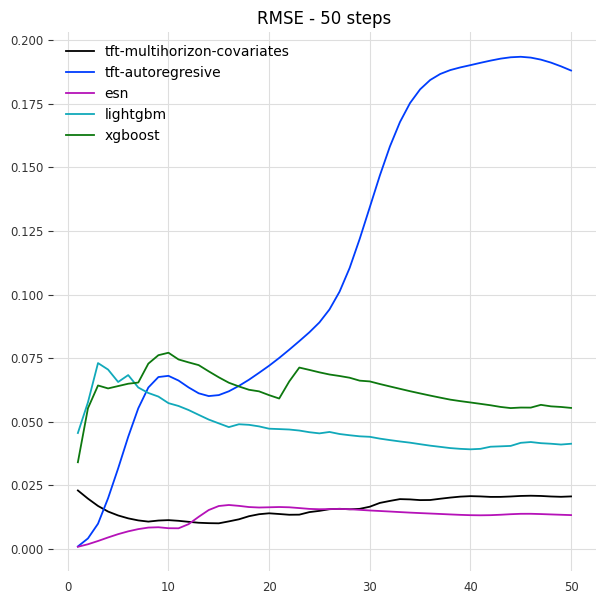

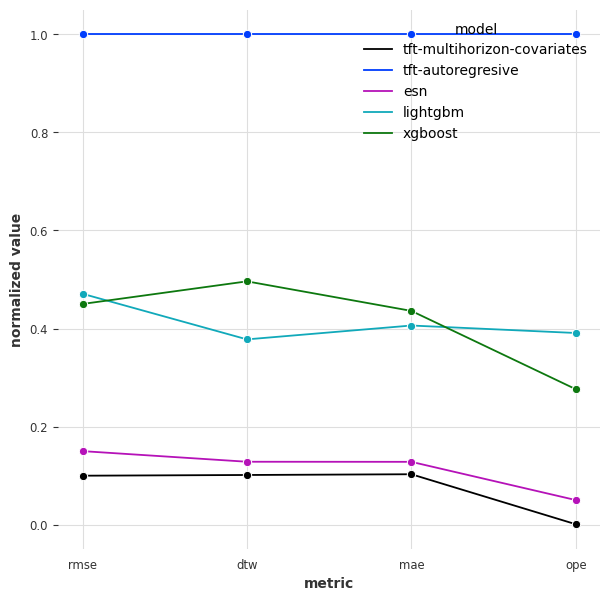

dataset name                   model name  rmse - 1  rmse - 10  rmse - 20  \
0  mackey_glass  tft-multihorizon-covariates  0.022956   0.011288   0.013973   
1  mackey_glass            tft-autoregresive  0.000944   0.068021   0.072001   
2  mackey_glass                          esn  0.000811   0.008110   0.016341   
3  mackey_glass                     lightgbm  0.045543   0.057285   0.047238   
4  mackey_glass                      xgboost  0.034045   0.077102   0.060430   

   rmse - 50  rmse - 100 rmse - 250      rmse       dtw       mae        ope  
0   0.020611    0.021074       None  0.021456  0.009341  0.017920   0.022012  
1   0.188065    0.217573       None  0.213963  0.091827  0.173587  15.965019  
2   0.013267    0.022498       None  0.032168  0.011818  0.022310   0.808181  
3   0.041321    0.076327       None  0.100777  0.034718  0.070534   6.243940  
4   0.055410    0.084846       None  0.096346  0.045578  0.075709   4.415606

In [29]:
res_df = make_evaluation(mackey_glass)
EVALUATION_DF = pd.concat([EVALUATION_DF, res_df], ignore_index=True)

# Sunspots

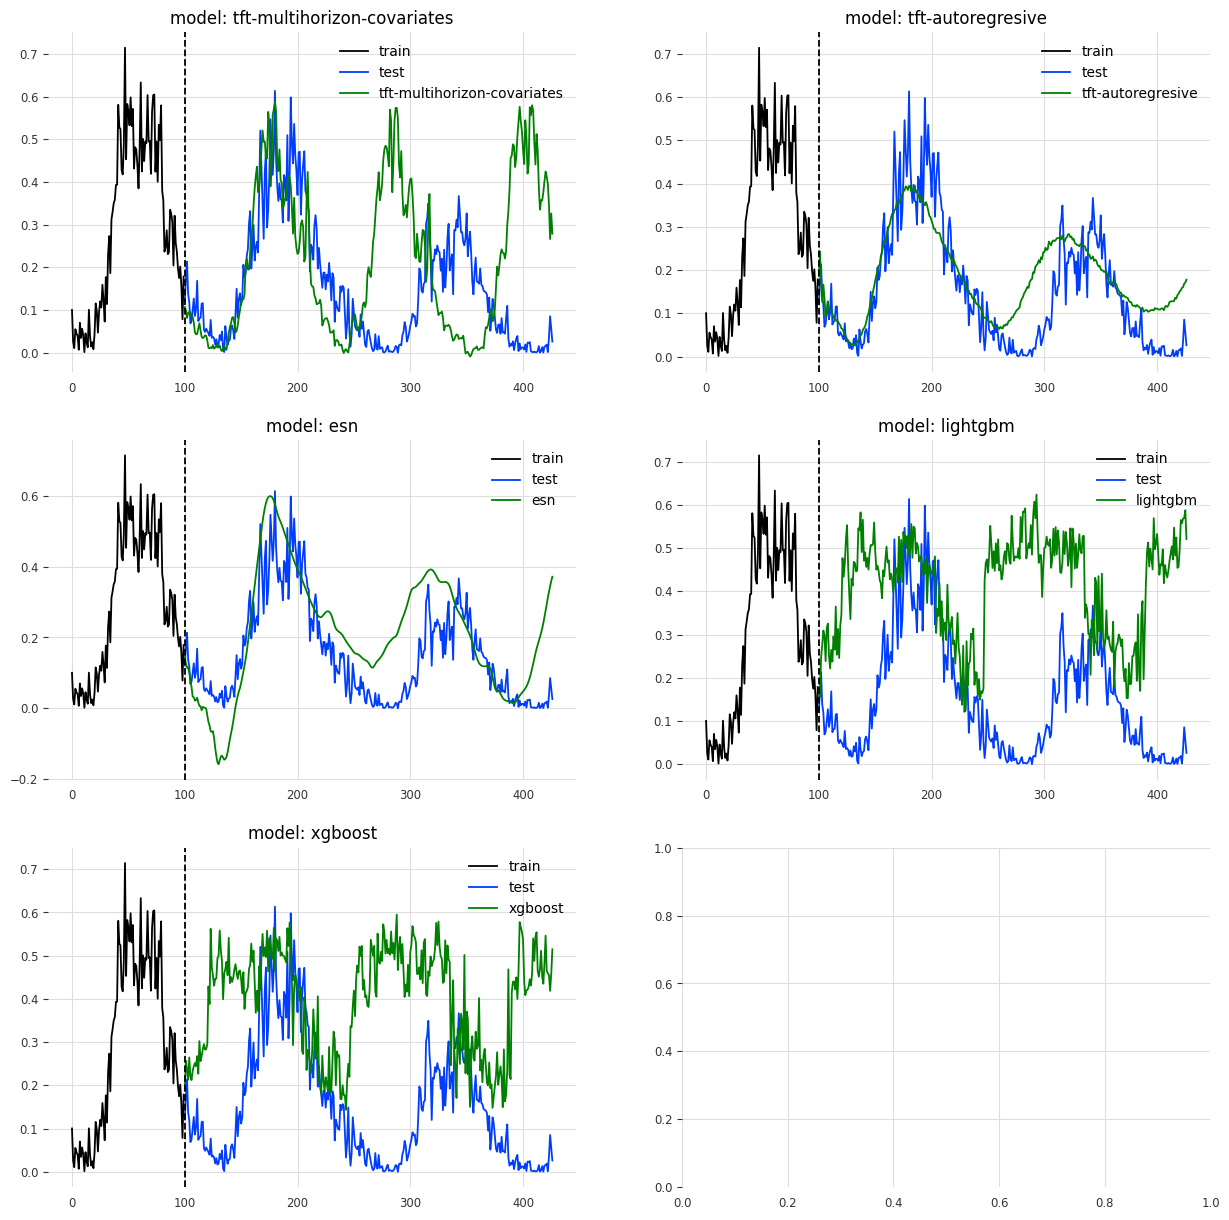

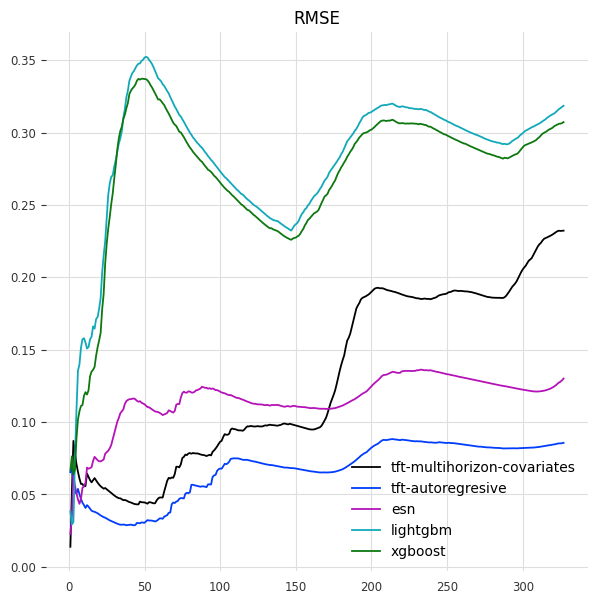

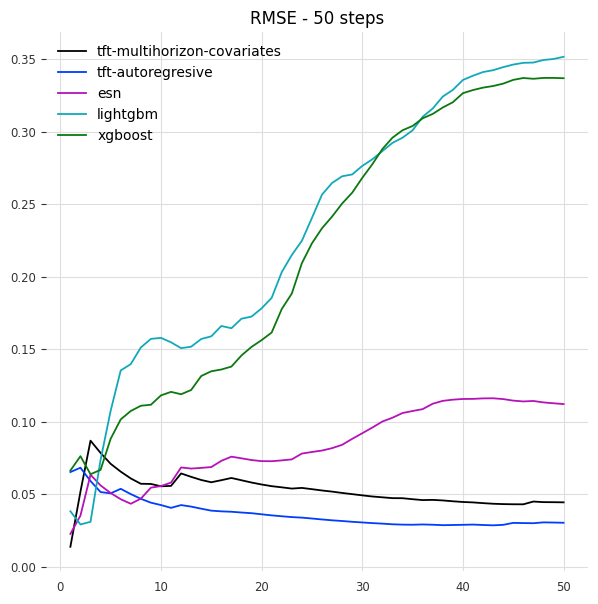

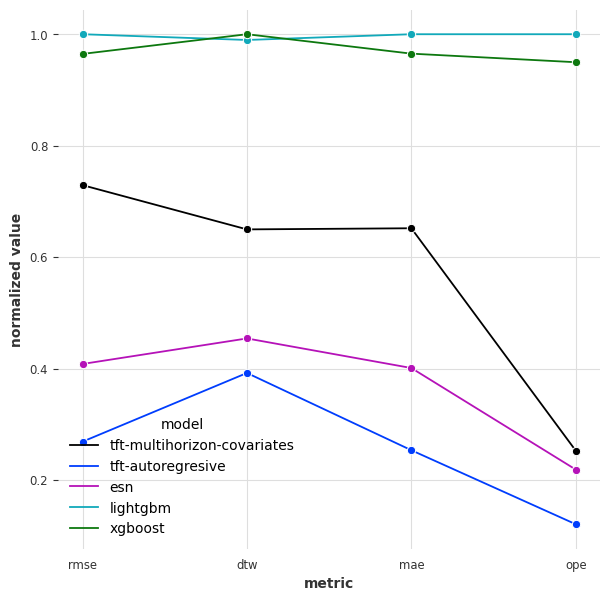

dataset name                   model name  rmse - 1  rmse - 10  rmse - 20  \
0     sunspots  tft-multihorizon-covariates  0.013868   0.055576   0.056813   
1     sunspots            tft-autoregresive  0.065380   0.042636   0.036261   
2     sunspots                          esn  0.022757   0.055713   0.072920   
3     sunspots                     lightgbm  0.038350   0.157907   0.178271   
4     sunspots                      xgboost  0.066413   0.118244   0.156345   

   rmse - 50  rmse - 100  rmse - 250      rmse       dtw       mae         ope  
0   0.044505    0.086436    0.188916  0.232213  0.055178  0.173552   42.570272  
1   0.030428    0.067908    0.085522  0.085675  0.033306  0.067537   20.355663  
2   0.112267    0.121003    0.133045  0.130058  0.038567  0.106804   36.860494  
3   0.351697    0.273170    0.307816  0.318431  0.084030  0.266231  168.319770  
4   0.336914    0.265367    0.298002  0.307187  0.084906  0.256955  159.865445

In [30]:
res_df = make_evaluation(sunspots)
EVALUATION_DF = pd.concat([EVALUATION_DF, res_df], ignore_index=True)

# Electricity

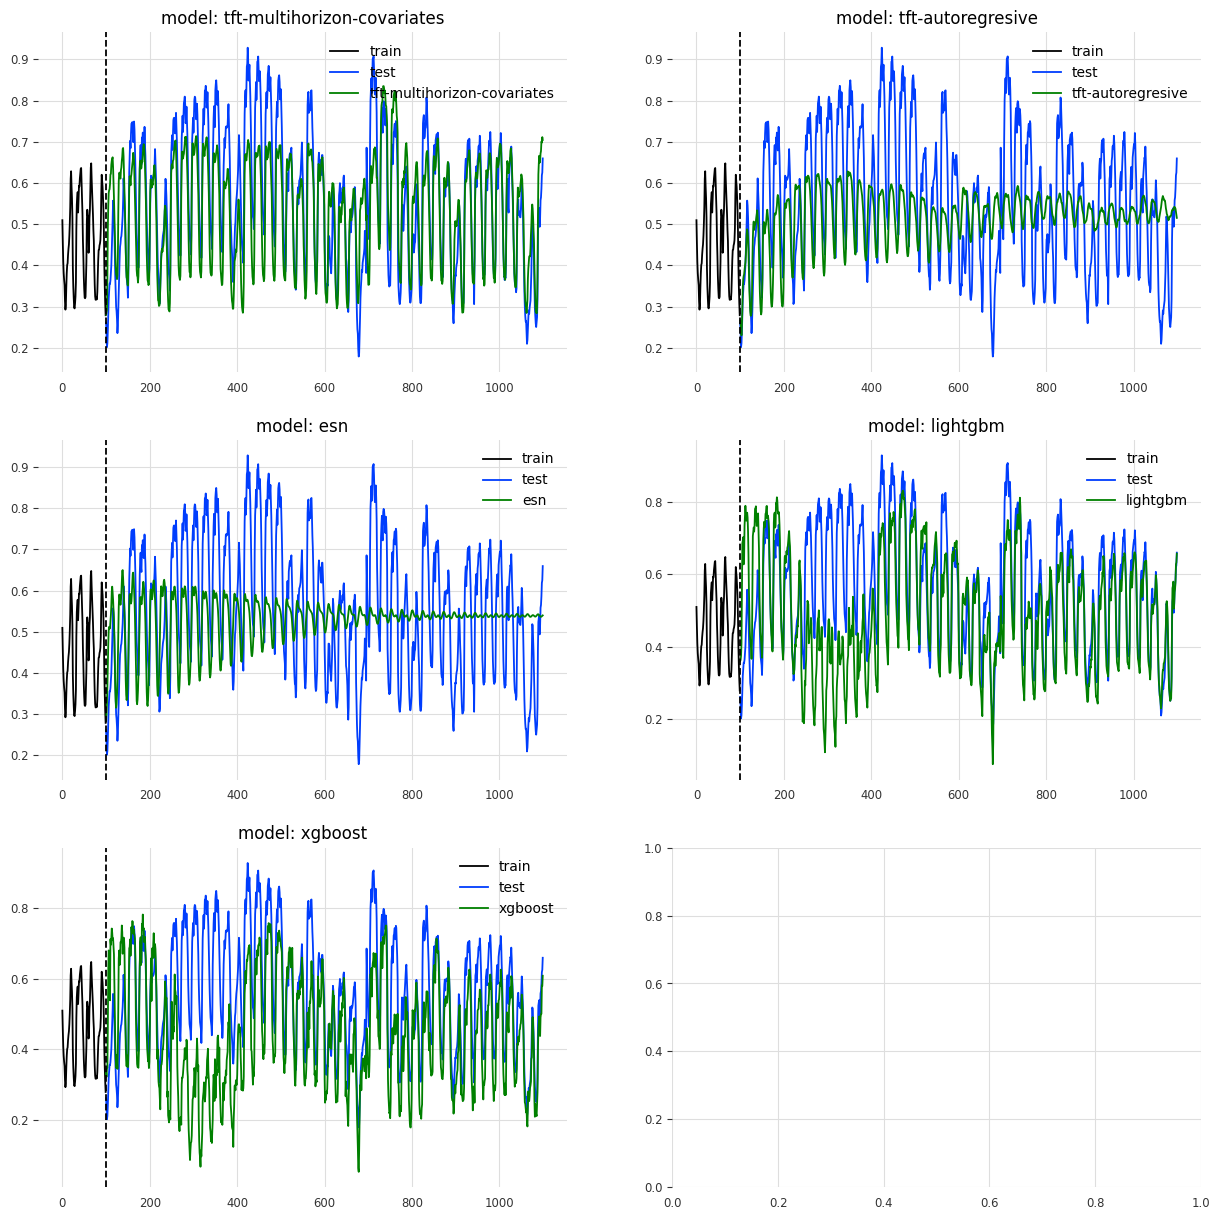

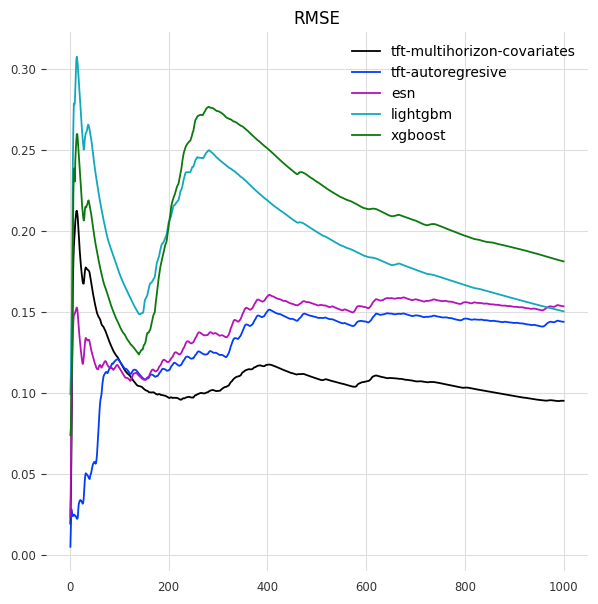

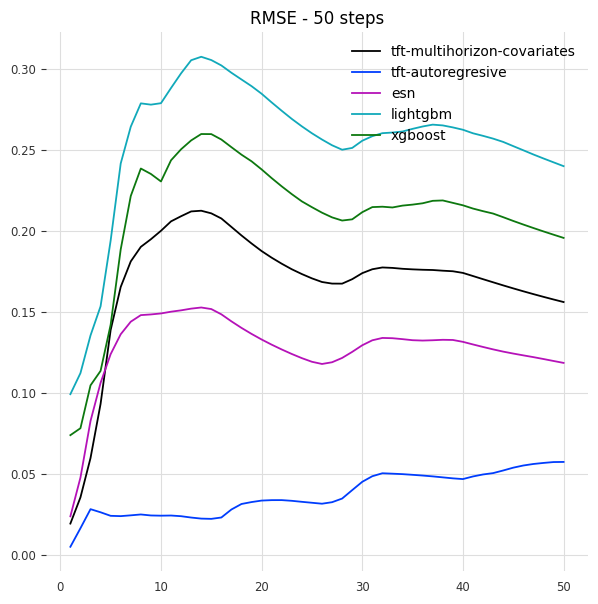

Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.


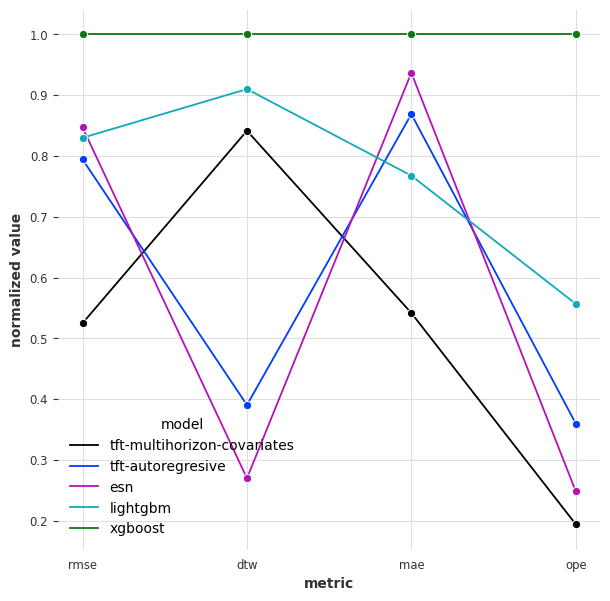

dataset name                   model name  rmse - 1  rmse - 10  rmse - 20  \
0  electricity  tft-multihorizon-covariates  0.019273   0.200180   0.187656   
1  electricity            tft-autoregresive  0.004936   0.024153   0.033485   
2  electricity                          esn  0.023762   0.149108   0.133014   
3  electricity                     lightgbm  0.099221   0.279021   0.284854   
4  electricity                      xgboost  0.073904   0.230660   0.238104   

   rmse - 50  rmse - 100  rmse - 250      rmse       dtw       mae        ope  
0   0.156160    0.120218    0.097099  0.095139  0.066433  0.074536   4.031174  
1   0.057359    0.119788    0.121347  0.143945  0.030826  0.119530   7.464462  
2   0.118555    0.115592    0.131213  0.153488  0.021311  0.128889   5.155500  
3   0.240125    0.174113    0.239740  0.150401  0.071843  0.105607  11.546617  
4   0.195794    0.141873    0.261718  0.181268  0.078967  0.137610  20.743216

In [31]:
res_df = make_evaluation(electricity)
EVALUATION_DF = pd.concat([EVALUATION_DF, res_df], ignore_index=True)

# Temperature

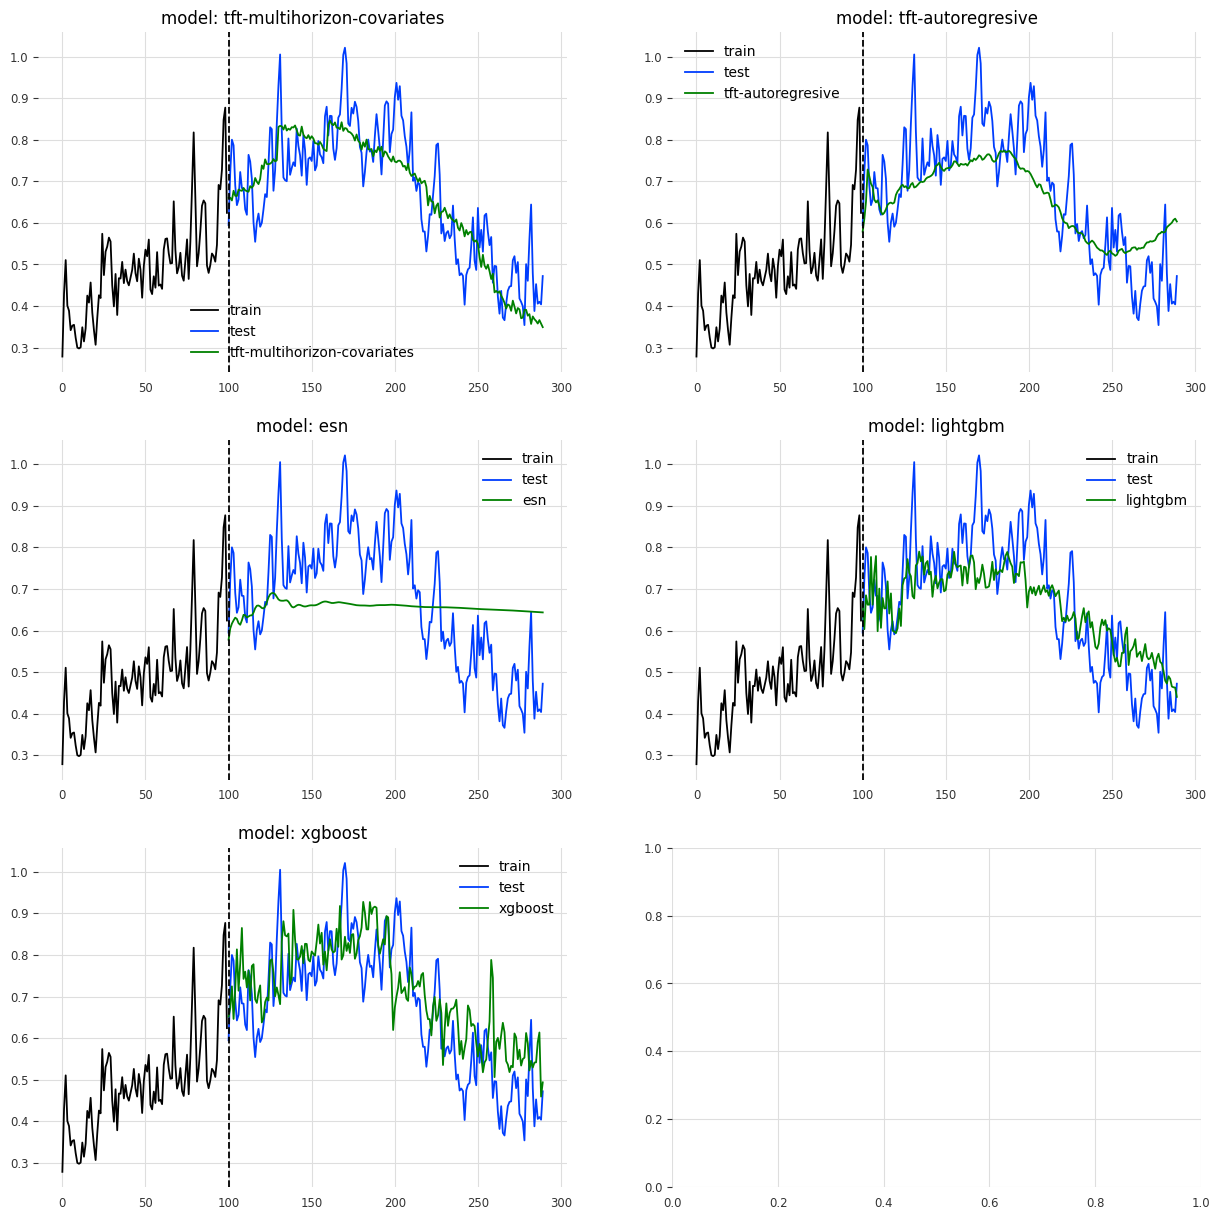

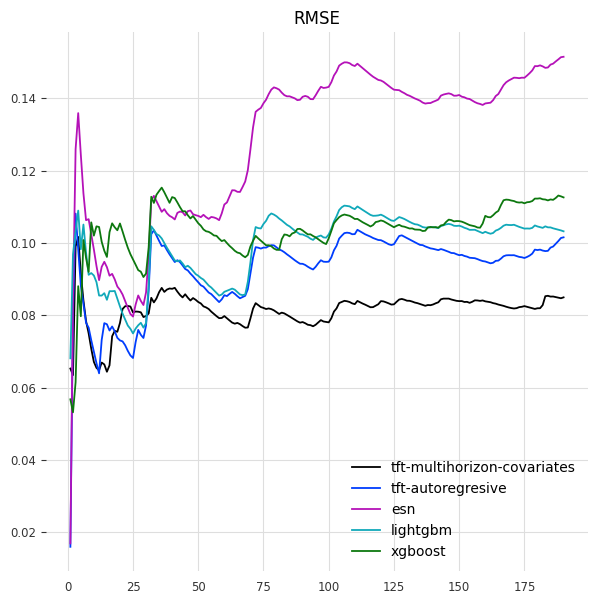

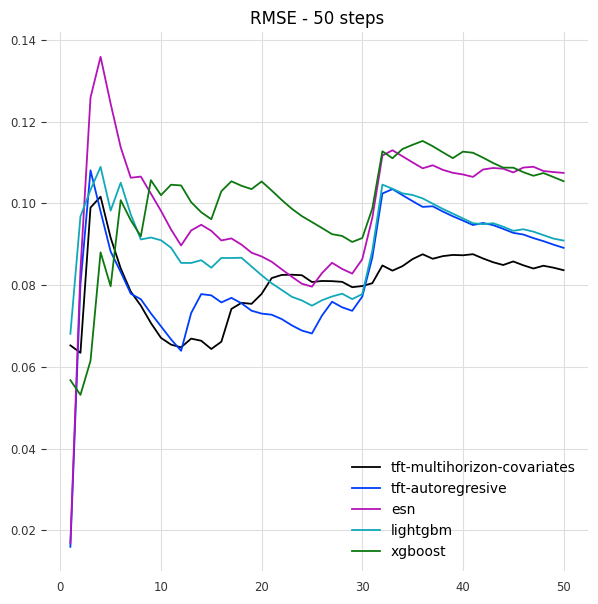

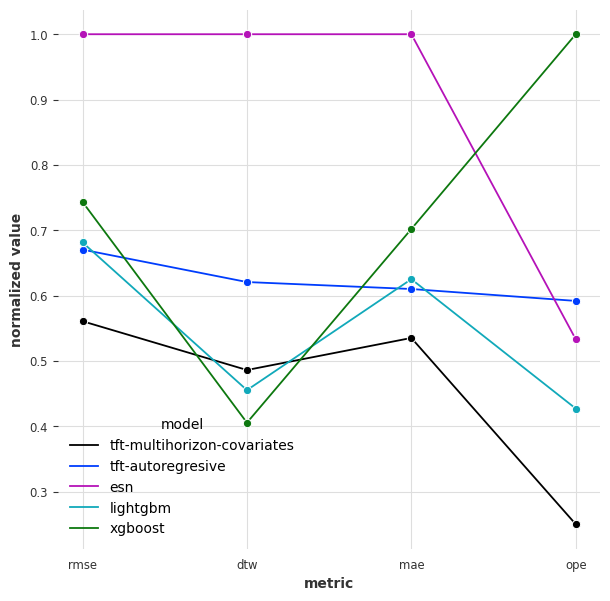

dataset name                   model name  rmse - 1  rmse - 10  rmse - 20  \
0  temperature  tft-multihorizon-covariates  0.065260   0.067104   0.077866   
1  temperature            tft-autoregresive  0.015979   0.069936   0.073039   
2  temperature                          esn  0.016916   0.098188   0.087017   
3  temperature                     lightgbm  0.068091   0.090985   0.082429   
4  temperature                      xgboost  0.056749   0.102009   0.105369   

   rmse - 50  rmse - 100 rmse - 250      rmse       dtw       mae       ope  
0   0.083660    0.078030       None  0.084943  0.036843  0.069637  1.445383  
1   0.089129    0.094806       None  0.101540  0.047045  0.079379  3.419485  
2   0.107467    0.143143       None  0.151463  0.075783  0.130105  3.080609  
3   0.090912    0.102338       None  0.103206  0.034509  0.081343  2.467824  
4   0.105440    0.101266       None  0.112583  0.030734  0.091326  5.777015

In [32]:
res_df = make_evaluation(temperature)
EVALUATION_DF = pd.concat([EVALUATION_DF, res_df], ignore_index=True)

In [33]:
EVALUATION_DF

dataset name                   model name  rmse - 1  rmse - 10  rmse - 20  \
0   mackey_glass  tft-multihorizon-covariates  0.022956   0.011288   0.013973   
1   mackey_glass            tft-autoregresive  0.000944   0.068021   0.072001   
2   mackey_glass                          esn  0.000811   0.008110   0.016341   
3   mackey_glass                     lightgbm  0.045543   0.057285   0.047238   
4   mackey_glass                      xgboost  0.034045   0.077102   0.060430   
5       sunspots  tft-multihorizon-covariates  0.013868   0.055576   0.056813   
6       sunspots            tft-autoregresive  0.065380   0.042636   0.036261   
7       sunspots                          esn  0.022757   0.055713   0.072920   
8       sunspots                     lightgbm  0.038350   0.157907   0.178271   
9       sunspots                      xgboost  0.066413   0.118244   0.156345   
10   electricity  tft-multihorizon-covariates  0.019273   0.200180   0.187656   
11   electricity            tft-autoregresive  0.004936   0.024153   0.033485   
12   electricity                          esn  0.023762   0.149108   0.133014   
13   electricity                     lightgbm  0.099221   0.279021   0.284854   
14   electricity                      xgboost  0.073904   0.230660   0.238104   
15   temperature  tft-multihorizon-covariates  0.065260   0.067104   0.077866   
16   temperature            tft-autoregresive  0.015979   0.069936   0.073039   
17   temperature                          esn  0.016916   0.098188   0.087017   
18   temperature                     lightgbm  0.068091   0.090985   0.082429   
19   temperature                      xgboost  0.056749   0.102009   0.105369   

    rmse - 50  rmse - 100 rmse - 250      rmse       dtw       mae         ope  
0    0.020611    0.021074        NaN  0.021456  0.009341  0.017920    0.022012  
1    0.188065    0.217573        NaN  0.213963  0.091827  0.173587   15.965019  
2    0.013267    0.022498        NaN  0.032168  0.011818  0.022310    0.808181  
3    0.041321    0.076327        NaN  0.100777  0.034718  0.070534    6.243940  
4    0.055410    0.084846        NaN  0.096346  0.045578  0.075709    4.415606  
5    0.044505    0.086436   0.188916  0.232213  0.055178  0.173552   42.570272  
6    0.030428    0.067908   0.085522  0.085675  0.033306  0.067537   20.355663  
7    0.112267    0.121003   0.133045  0.130058  0.038567  0.106804   36.860494  
8    0.351697    0.273170   0.307816  0.318431  0.084030  0.266231  168.319770  
9    0.336914    0.265367   0.298002  0.307187  0.084906  0.256955  159.865445  
10   0.156160    0.120218   0.097099  0.095139  0.066433  0.074536    4.031174  
11   0.057359    0.119788   0.121347  0.143945  0.030826  0.119530    7.464462  
12   0.118555    0.115592   0.131213  0.153488  0.021311  0.128889    5.155500  
13   0.240125    0.174113    0.23974  0.150401  0.071843  0.105607   11.546617  
14   0.195794    0.141873   0.261718  0.181268  0.078967  0.137610   20.743216  
15   0.083660    0.078030       None  0.084943  0.036843  0.069637    1.445383  
16   0.089129    0.094806       None  0.101540  0.047045  0.079379    3.419485  
17   0.107467    0.143143       None  0.151463  0.075783  0.130105    3.080609  
18   0.090912    0.102338       None  0.103206  0.034509  0.081343    2.467824  
19   0.105440    0.101266       None  0.112583  0.030734  0.091326    5.777015